In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

In [7]:
df = pd.read_csv('final_combined_dataset.csv')


In [8]:
df.dtypes

date                                     object
week                                      int64
cases                                     int64
population                                int64
tempe_min                               float64
humidity_max                            float64
humidity_avg                            float64
humidity_min                            float64
temp_avg                                float64
temp_max                                float64
city                                     object
geocode                                   int64
vim                                     float64
vim_monthly                             float64
precipitation_avg_ordinary_kriging      float64
precipitation_max_ordinary_kriging      float64
precipitation_avg_regression_kriging    float64
precipitation_max_regression_kriging    float64
long                                    float64
lat                                     float64
cases_per_100k                          

In [9]:
from sklearn.preprocessing import LabelEncoder


df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())

# df["cases_rolling_mean"] = df.groupby("geocode")["cases"].transform(lambda x: x.rolling(4).mean())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[1, 2,3,4])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[4, 5, 6])
data = data.dropna().reset_index(drop=True)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse_output=False), ['geocode'])  # One-hot encode 'geocode'
], remainder='passthrough')  # Keep all other columns as is

transformed_data = ct.fit_transform(data)

# Get feature names
feature_names = ct.get_feature_names_out()

# Clean feature names to remove 'remainder__' prefix
cleaned_feature_names = [name.split('__')[-1] if 'remainder__' in name else name for name in feature_names]

# Convert transformed data back to DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=cleaned_feature_names)

numeric_cols = data.select_dtypes(include=['float64', 'int64','int32']).columns
for col in numeric_cols:
    if col in transformed_df.columns:
        transformed_df[col] = pd.to_numeric(transformed_df[col], errors='coerce')

if 'date' in transformed_df.columns:
    transformed_df['date'] = pd.to_datetime(transformed_df['date'], errors='coerce')

print(transformed_df.dtypes)
data= transformed_df

# Now 'transformed_df' contains the transformed data with the correct types
print(transformed_df.dtypes) 

train_data = data[data['date'].dt.year <= 2020]
test_data = data[data['date'].dt.year >= 2021]

X_train = train_data.drop(columns=['cases','cases_per_100k'])
y_train = train_data[['cases']]

X_test = test_data.drop(columns=['cases','cases_per_100k'])
y_test = test_data[['cases']]

data = data.drop(columns=['cases_per_100k'])

data

onehot__geocode_3300100                       object
onehot__geocode_3300159                       object
onehot__geocode_3300209                       object
onehot__geocode_3300225                       object
onehot__geocode_3300233                       object
                                              ...   
precipitation_avg_regression_kriging_lag5    float64
precipitation_avg_regression_kriging_lag6    float64
precipitation_max_regression_kriging_lag4    float64
precipitation_max_regression_kriging_lag5    float64
precipitation_max_regression_kriging_lag6    float64
Length: 155, dtype: object
onehot__geocode_3300100                       object
onehot__geocode_3300159                       object
onehot__geocode_3300209                       object
onehot__geocode_3300225                       object
onehot__geocode_3300233                       object
                                              ...   
precipitation_avg_regression_kriging_lag5    float64
precipitation_avg_r

onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geocode_3300233 onehot__geocode_3300258  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300308 onehot__geocode_3300407 onehot__geocode_3300456  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300506  ... precipitation_avg_ordinary_kriging_lag6  \
0                         0.0  ...                                  5.6804   
1                         0.0  ...                                  4.0716   
2                         0.0  ...                                  2.0555   
3                         0.0  ...                                  1.5416   
4                         0.0  ...                                  2.8204   
...                       ...  ...                                     ...   
51683                     0.0  ...                                  1.1280   
51684                     0.0  ...                                  2.3012   
51685                     0.0  ...                                  3.9107   
51686                     0.0  ...                                  3.5073   
51687                     0.0  ...                                  2.2254   

      precipitation_max_ordinary_kriging_lag4  \
0                                      5.0500   
1                                      5.7059   
2  

In [10]:
data.dtypes

onehot__geocode_3300100                       object
onehot__geocode_3300159                       object
onehot__geocode_3300209                       object
onehot__geocode_3300225                       object
onehot__geocode_3300233                       object
                                              ...   
precipitation_avg_regression_kriging_lag5    float64
precipitation_avg_regression_kriging_lag6    float64
precipitation_max_regression_kriging_lag4    float64
precipitation_max_regression_kriging_lag5    float64
precipitation_max_regression_kriging_lag6    float64
Length: 154, dtype: object

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Step 1-6: Keep the previous preprocessing steps the same (data preparation, scaling, etc.)
# Step 1: Define which columns to scale
columns_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                    'geocode', 'year_sin', 'year_cos'] + [col for col in data.columns if col.startswith('onehot__geocode_')]

# Step 2: Define which features you'll actually use for modeling
feature_cols = [
    'cases_lag1', 'cases_lag2', 'cases_lag3', 'cases_lag4',
    # Uncomment these if you want to use them
    # 'temp_avg_lag4', 'humidity_avg_lag4',
    # 'precipitation_max_regression_kriging_lag4',
    # 'week_sin', 'month_sin', 'week_cos', 'month_cos',
    # 'year_sin', 'year_cos'
]

# Add one-hot encoded columns
selected_columns = feature_cols + [col for col in data.columns if col.startswith('onehot_')]

# Step 3: Prepare feature matrix with only selected columns
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

# Step 4: Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Step 5: Scale features - only scale numeric features within selected_columns
numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and not col.startswith('onehot_')]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

# Step 6: Scale target variable (ensuring proper shape)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

# Store best model and its performance
# Parameter combinations
C_values = [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
epsilon_values = [0.0001, 0.001, 0.01, 0.1]
kernel = "linear"  # Only using linear kernel

# Initialize best RMSE tracker
best_rmse = float("inf")
best_model = None
best_params = {}

# Iterate through parameter combinations
for C in C_values:
    for epsilon in epsilon_values:
        # Create SVR model with current parameters
        svr_params = {'C': C, 'epsilon': epsilon, 'kernel': kernel}
        svr = SVR(**svr_params)
        svr.fit(X_train, y_train_scaled)

        # Predict and calculate RMSE
        y_pred_scaled = svr.predict(X_test)

        # Inverse transform predictions
        y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

        # Calculate Root Mean Squared Error
        rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
        print(f"Kernel: {kernel}, C: {C}, Epsilon: {epsilon}, RMSE: {rmse:.4f}")

        # Update best model if current model performs better
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = svr
            best_params = svr_params

print("\nBest Model Parameters:", best_params)
print("Best RMSE:", best_rmse)


# Final predictions using best model
y_pred_scaled = best_model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Prepare test dataframe with results
X_test_df = pd.DataFrame(X_test, columns=selected_columns)
X_test_df["actual"] = y_test_original
X_test_df["predicted"] = y_pred

# Plot Actual vs Predicted for each one-hot encoded geocode column
for geocode in X_test_df.columns:
    if geocode.startswith('onehot__geocode_'):
        # Filter the subset for rows where the current geocode column is 1
        subset = X_test_df[X_test_df[geocode] == 1]
        
        # Plot actual vs predicted cases
        plt.figure(figsize=(12, 6))
        plt.plot(subset.index, subset["actual"], label='Actual')
        plt.plot(subset.index, subset["predicted"], label='Predicted')
        plt.xlabel("Index")
        plt.ylabel("Cases")
        plt.title(f"Actual vs Predicted for Geocode {geocode}")
        plt.legend()
        plt.show()


# Additional performance metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100, "%")

Kernel: linear, C: 0.1, Epsilon: 0.0001, RMSE: 4.6455
Kernel: linear, C: 0.1, Epsilon: 0.001, RMSE: 5.6989
Kernel: linear, C: 0.1, Epsilon: 0.01, RMSE: 59.1946
Kernel: linear, C: 0.1, Epsilon: 0.1, RMSE: 1138.2772
Kernel: linear, C: 1, Epsilon: 0.0001, RMSE: 4.6971
Kernel: linear, C: 1, Epsilon: 0.001, RMSE: 4.6852
Kernel: linear, C: 1, Epsilon: 0.01, RMSE: 32.0941
Kernel: linear, C: 1, Epsilon: 0.1, RMSE: 952.7647
Kernel: linear, C: 10, Epsilon: 0.0001, RMSE: 4.7936
Kernel: linear, C: 10, Epsilon: 0.001, RMSE: 5.4600
Kernel: linear, C: 10, Epsilon: 0.01, RMSE: 25.9878
Kernel: linear, C: 10, Epsilon: 0.1, RMSE: 474.2048
Kernel: linear, C: 20, Epsilon: 0.0001, RMSE: 4.9962
Kernel: linear, C: 20, Epsilon: 0.001, RMSE: 5.3571
Kernel: linear, C: 20, Epsilon: 0.01, RMSE: 26.4925
Kernel: linear, C: 20, Epsilon: 0.1, RMSE: 441.7084
Kernel: linear, C: 30, Epsilon: 0.0001, RMSE: 4.8256
Kernel: linear, C: 30, Epsilon: 0.001, RMSE: 5.2832
Kernel: linear, C: 30, Epsilon: 0.01, RMSE: 25.4935
Kernel

Kernel: rbf, C: 0.1, Gamma: 0.001, Epsilon: 0.01, RMSE: 151.5477
Kernel: linear, C: 0.1, Gamma: 0.001, Epsilon: 0.01, RMSE: 59.1946
Kernel: poly, C: 0.1, Gamma: 0.001, Epsilon: 0.01, Degree: 2, RMSE: 151.8578
Kernel: poly, C: 0.1, Gamma: 0.001, Epsilon: 0.01, Degree: 3, RMSE: 151.8566
Kernel: poly, C: 0.1, Gamma: 0.001, Epsilon: 0.01, Degree: 4, RMSE: 151.8566
Kernel: rbf, C: 0.1, Gamma: 0.001, Epsilon: 0.05, RMSE: 739.1246
Kernel: linear, C: 0.1, Gamma: 0.001, Epsilon: 0.05, RMSE: 431.4480
Kernel: poly, C: 0.1, Gamma: 0.001, Epsilon: 0.05, Degree: 2, RMSE: 739.5469
Kernel: poly, C: 0.1, Gamma: 0.001, Epsilon: 0.05, Degree: 3, RMSE: 739.5462
Kernel: poly, C: 0.1, Gamma: 0.001, Epsilon: 0.05, Degree: 4, RMSE: 739.5462
Kernel: rbf, C: 0.1, Gamma: 0.001, Epsilon: 0.1, RMSE: 1474.5299
Kernel: linear, C: 0.1, Gamma: 0.001, Epsilon: 0.1, RMSE: 1138.2772
Kernel: poly, C: 0.1, Gamma: 0.001, Epsilon: 0.1, Degree: 2, RMSE: 1474.8615
Kernel: poly, C: 0.1, Gamma: 0.001, Epsilon: 0.1, Degree: 3, RM

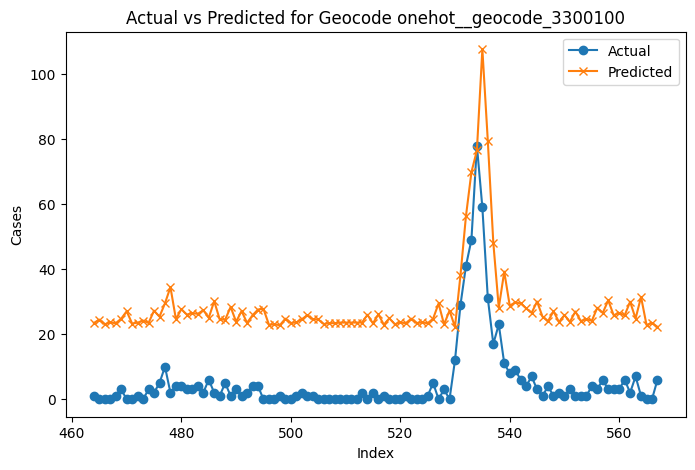

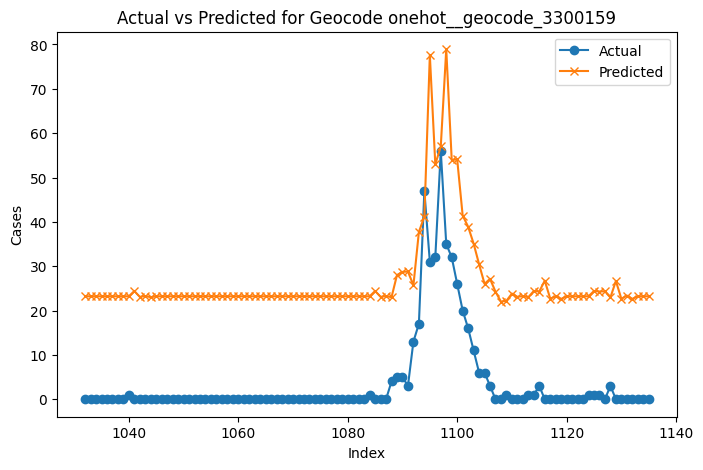

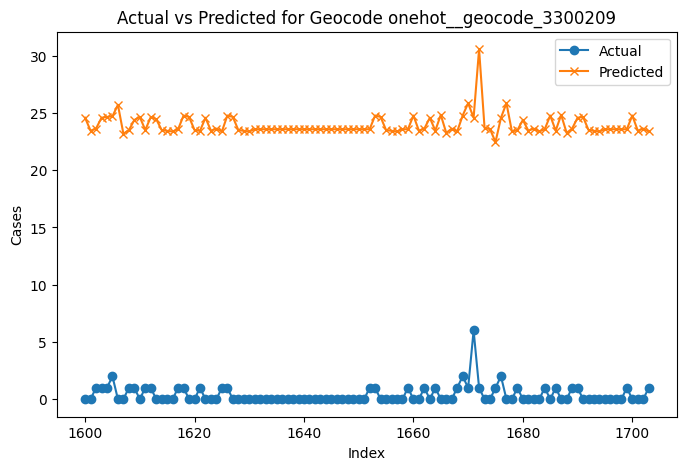

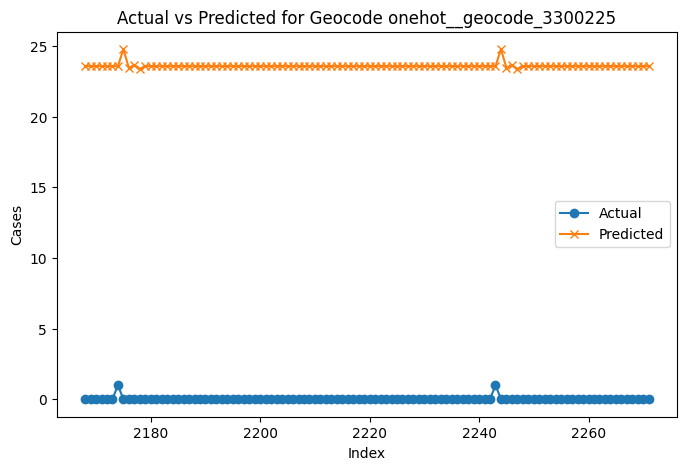

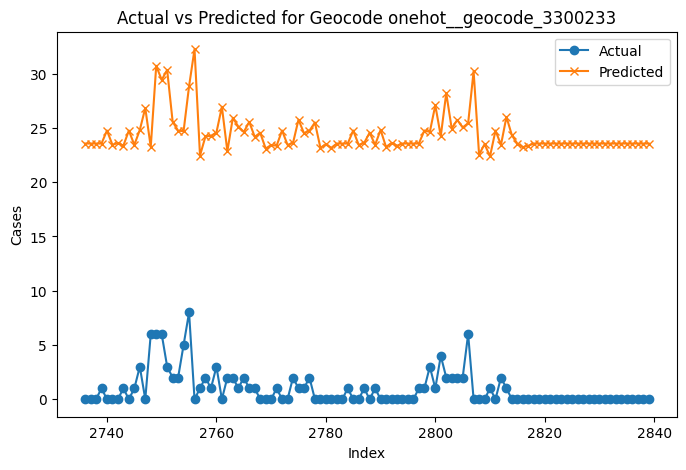

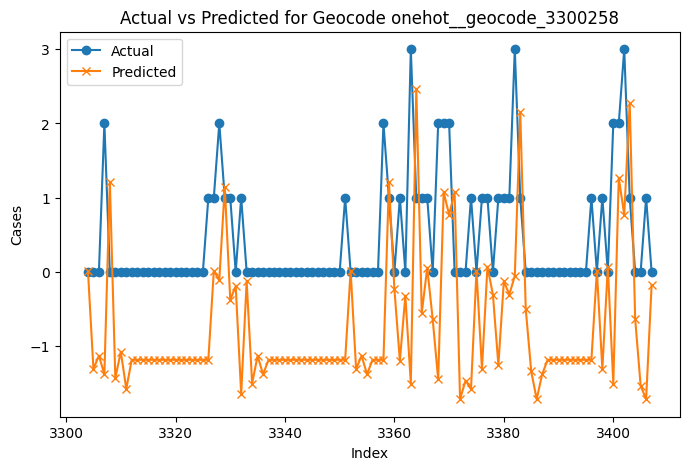

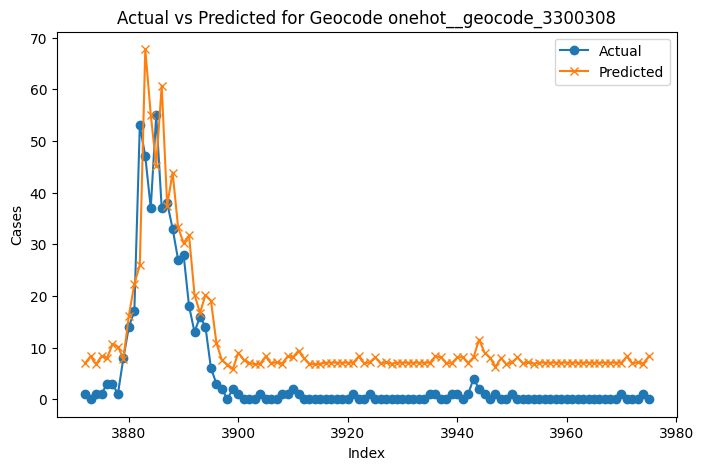

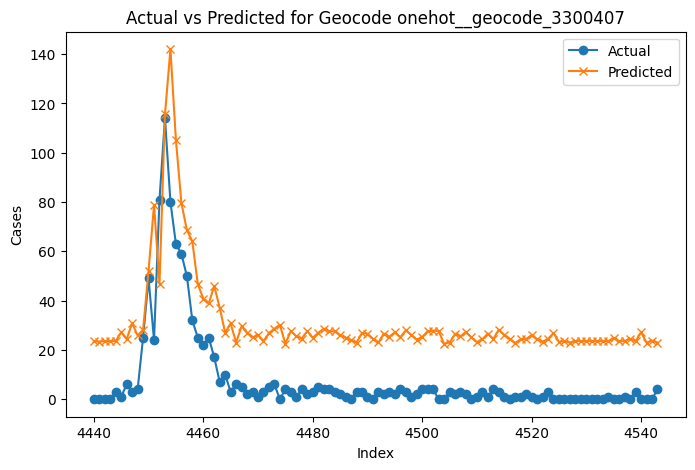

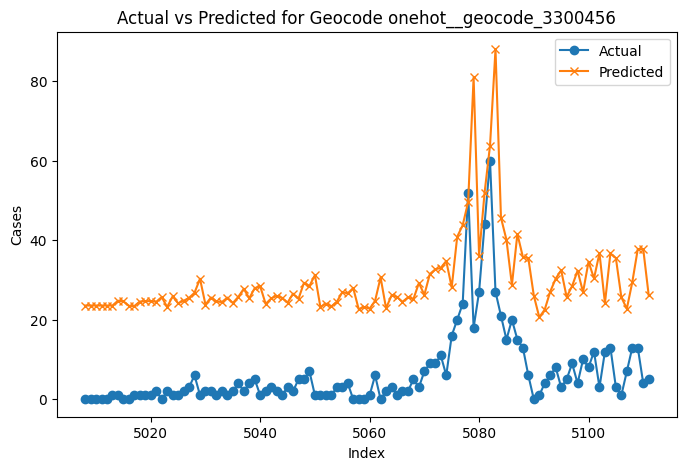

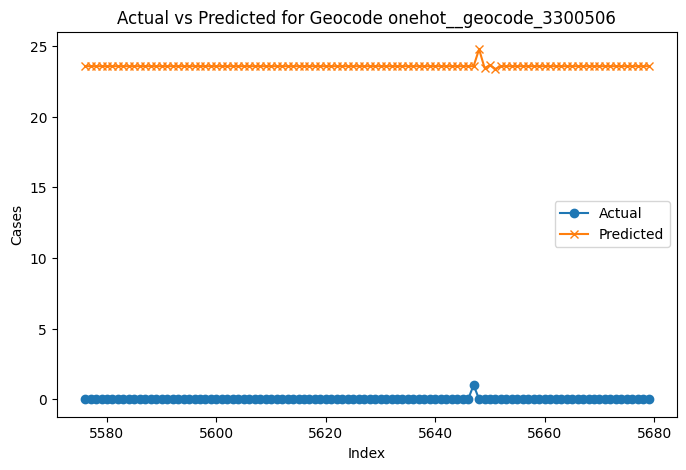

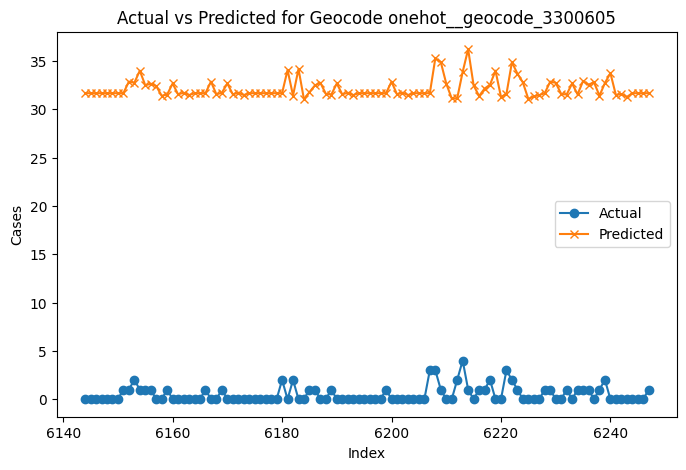

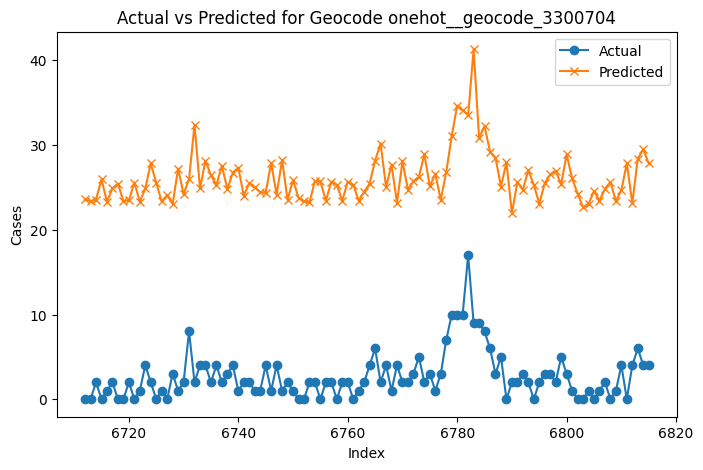

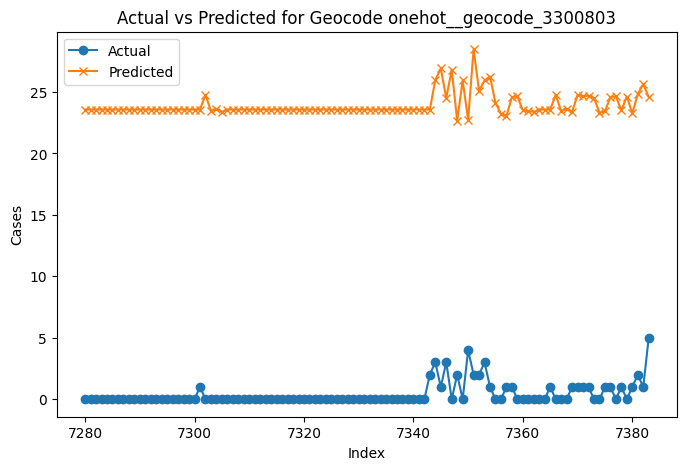

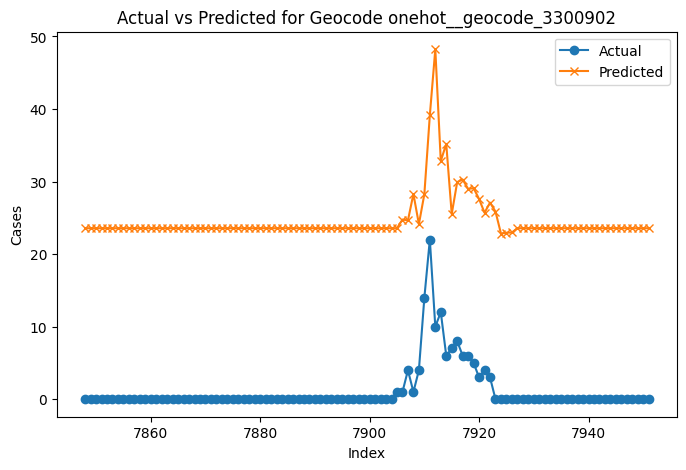

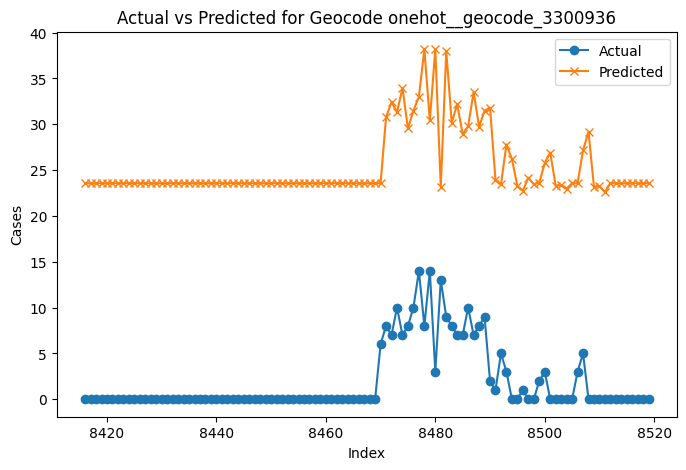

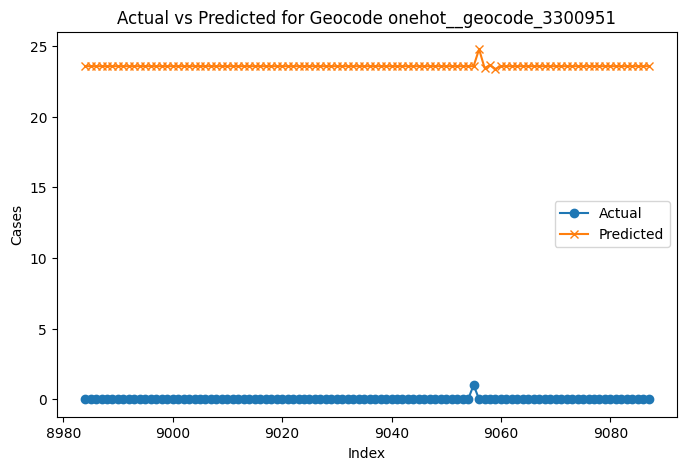

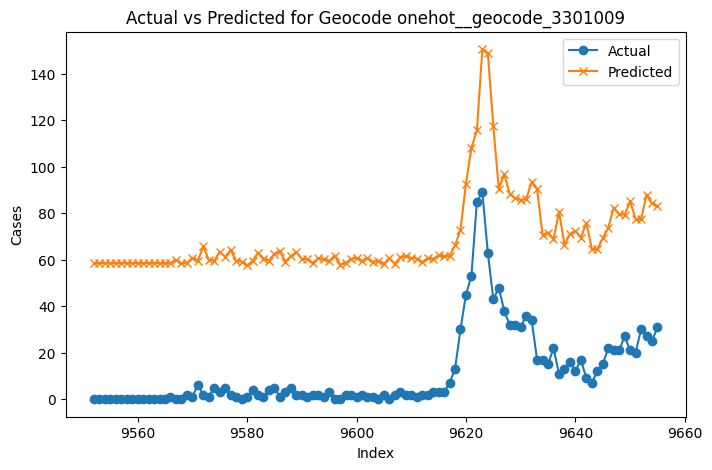

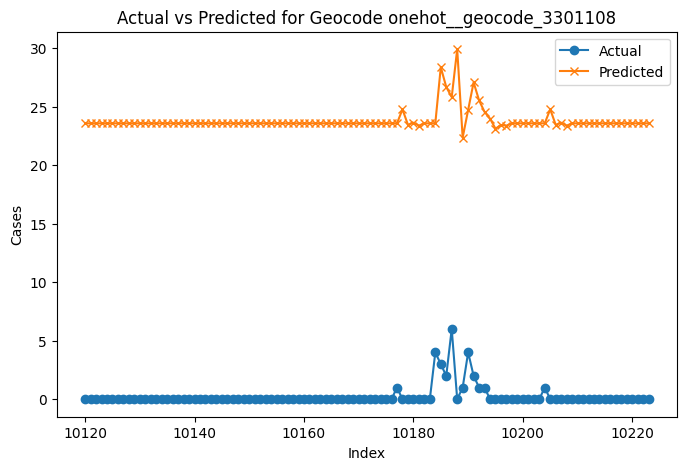

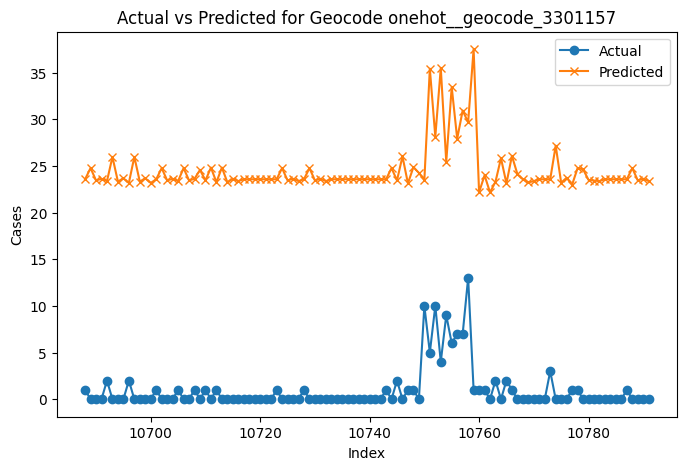

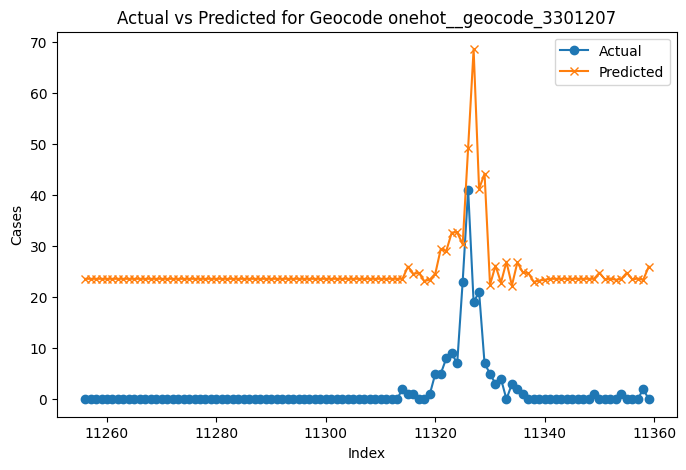

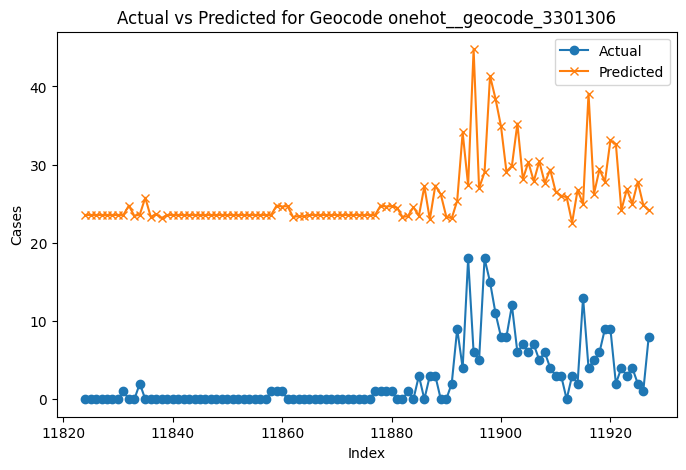

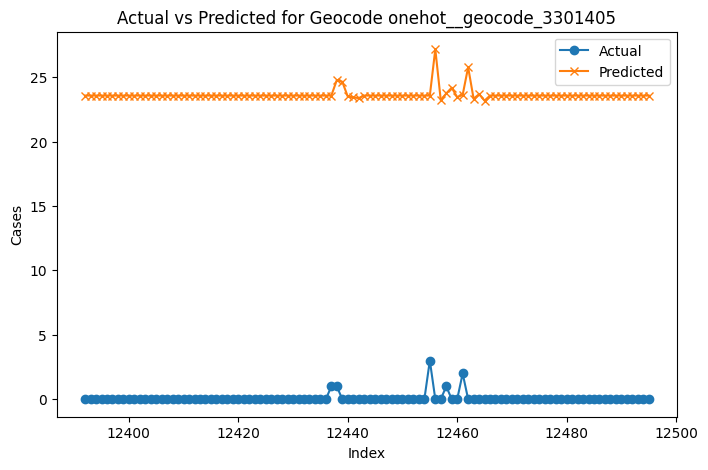

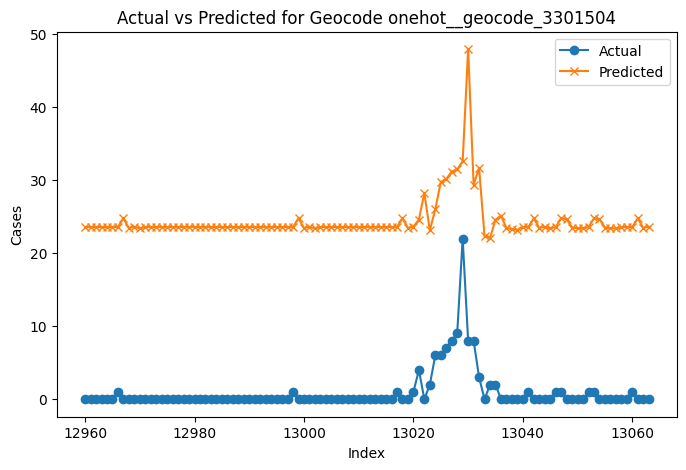

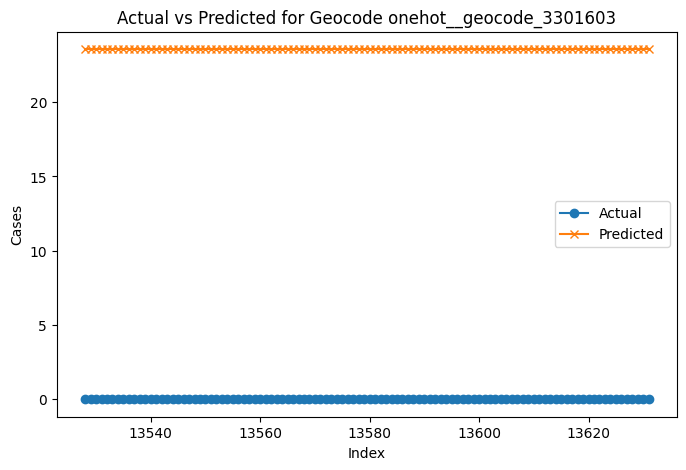

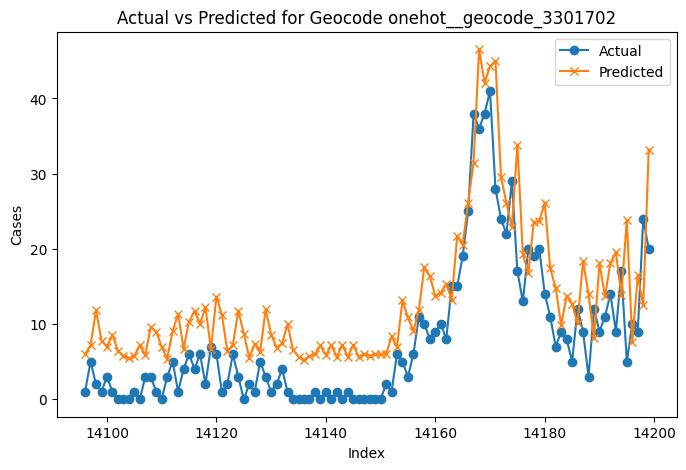

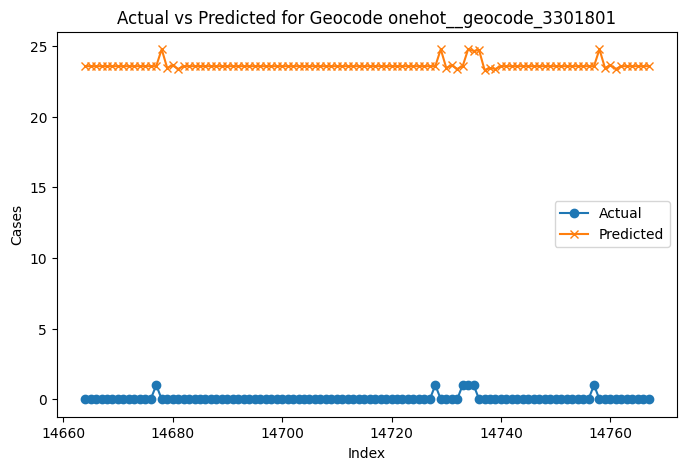

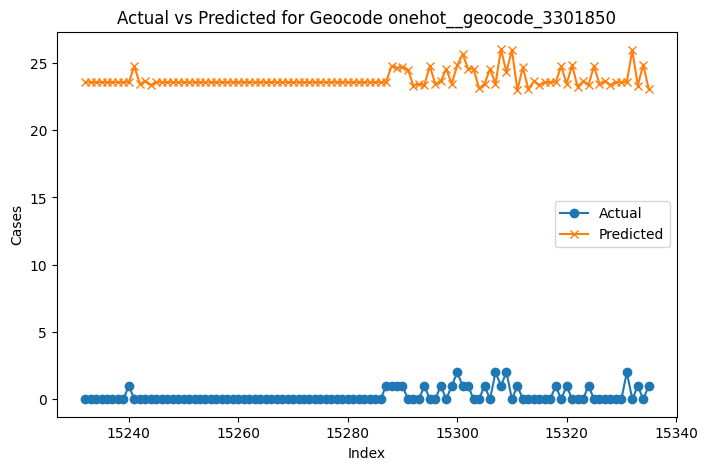

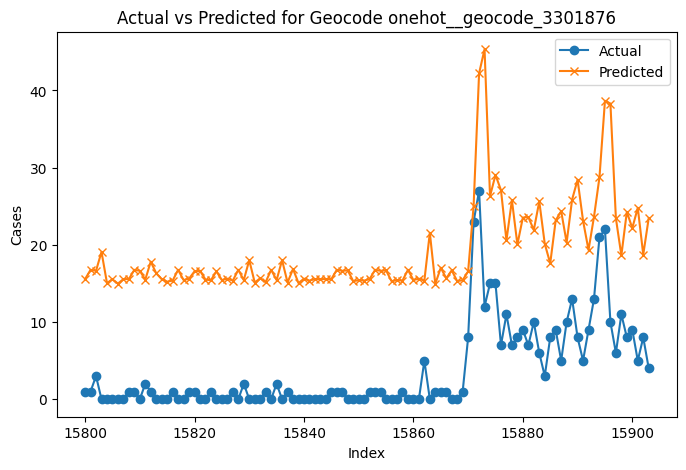

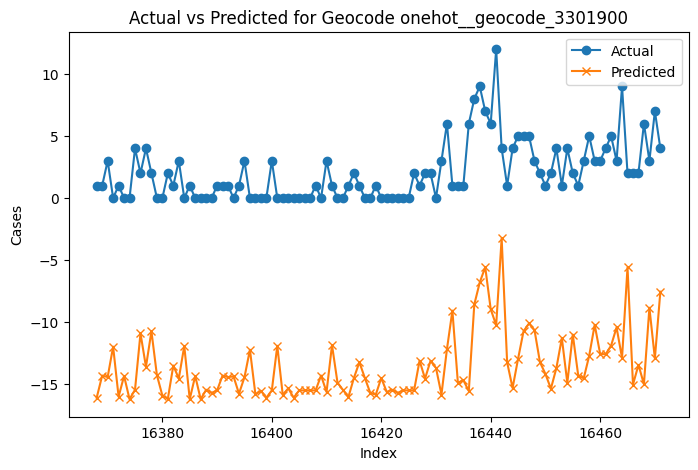

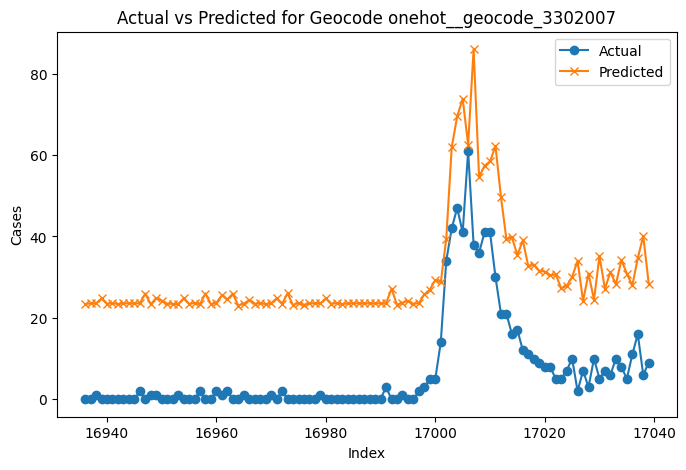

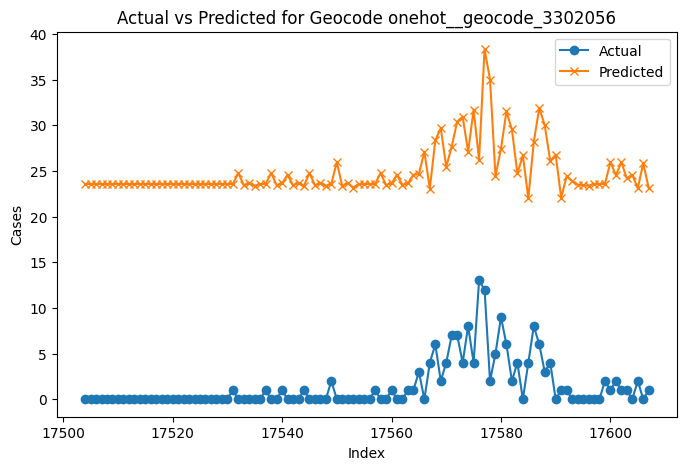

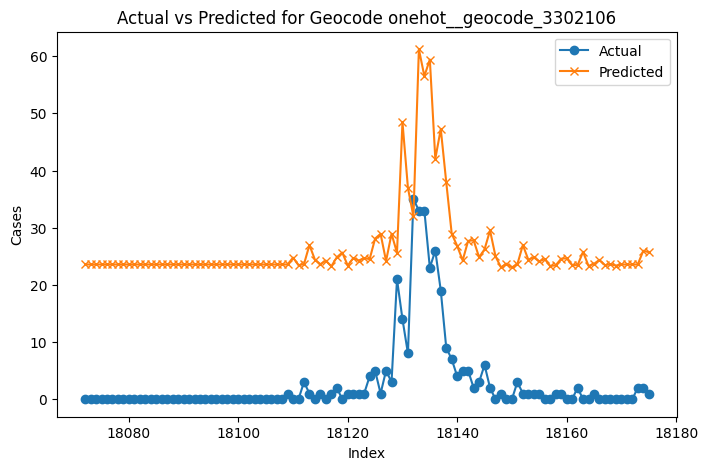

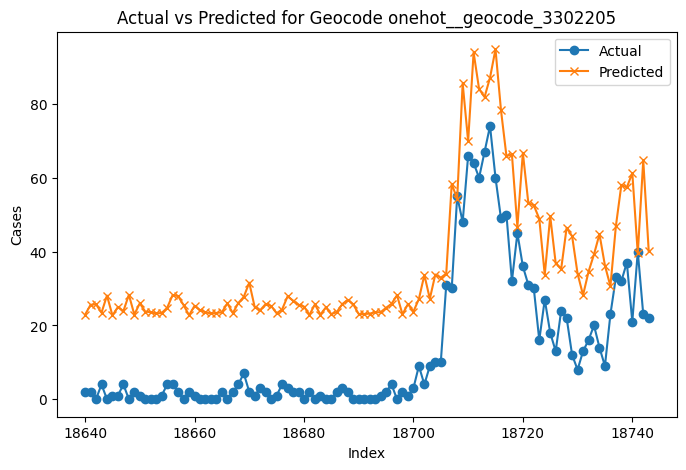

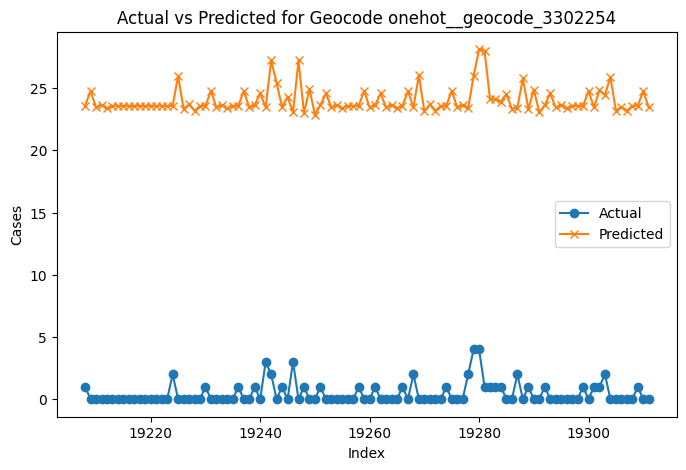

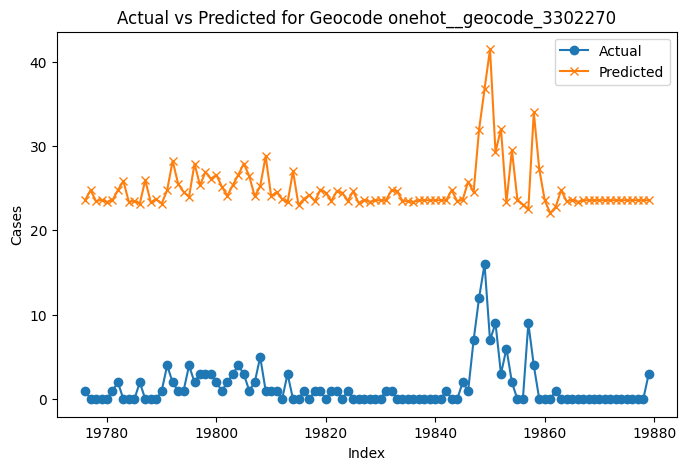

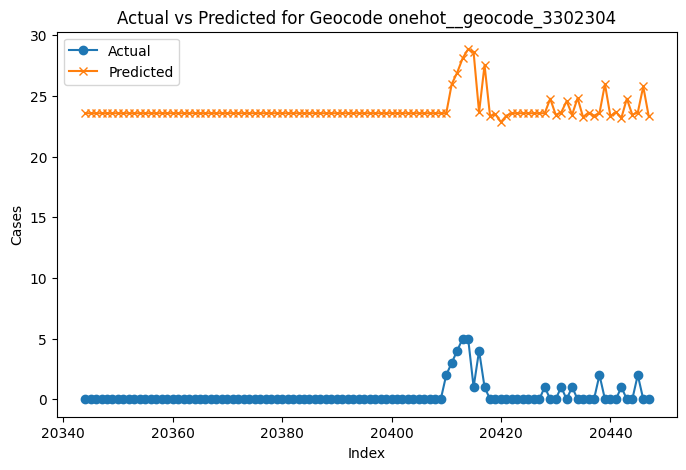

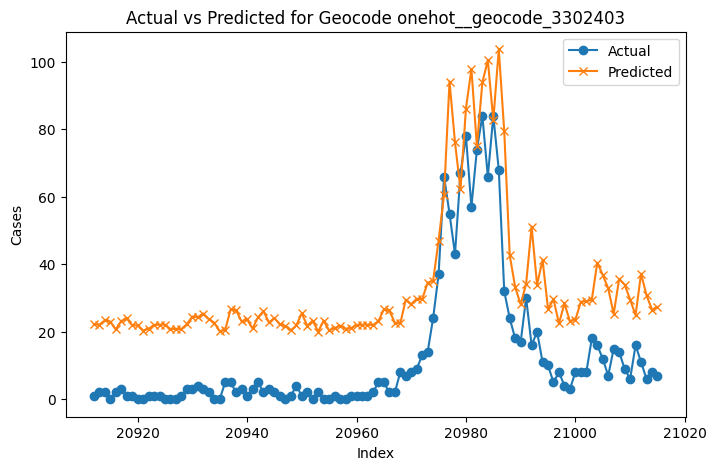

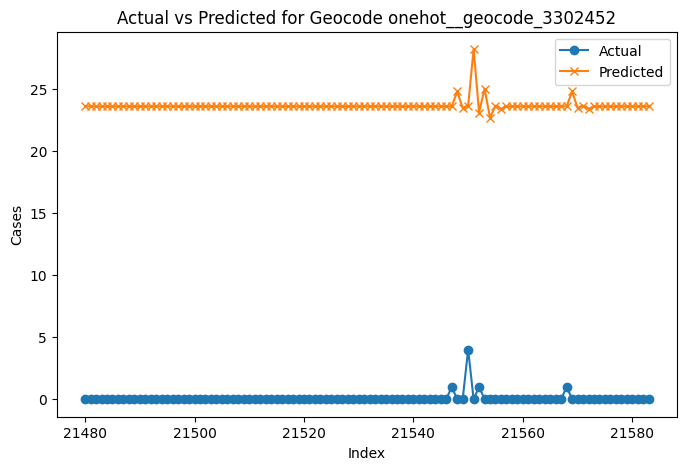

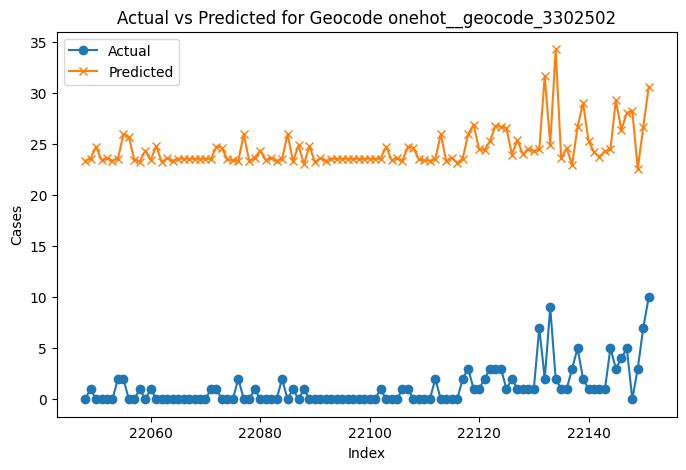

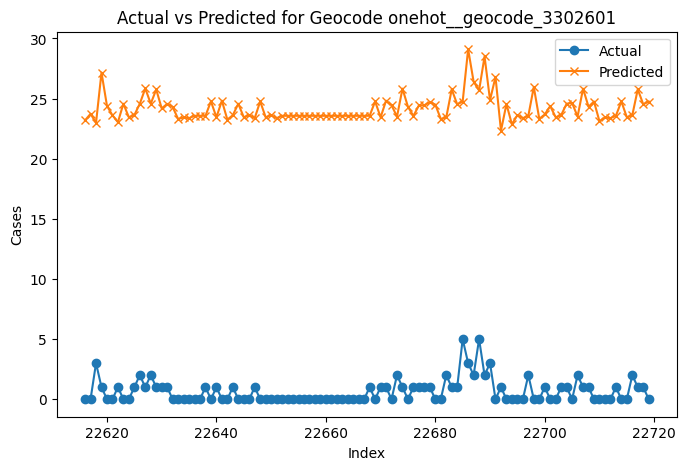

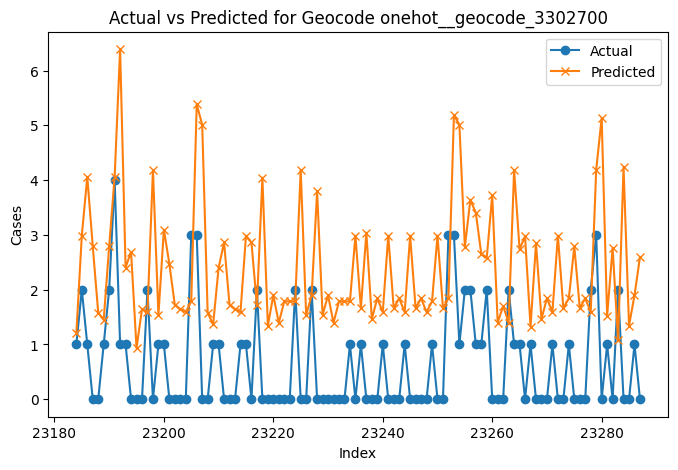

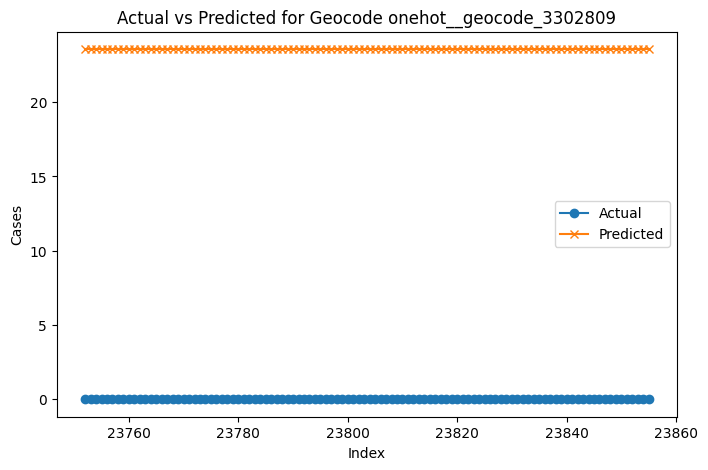

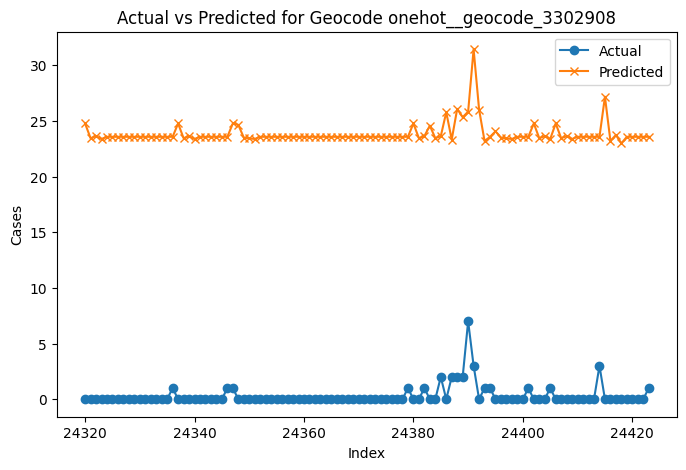

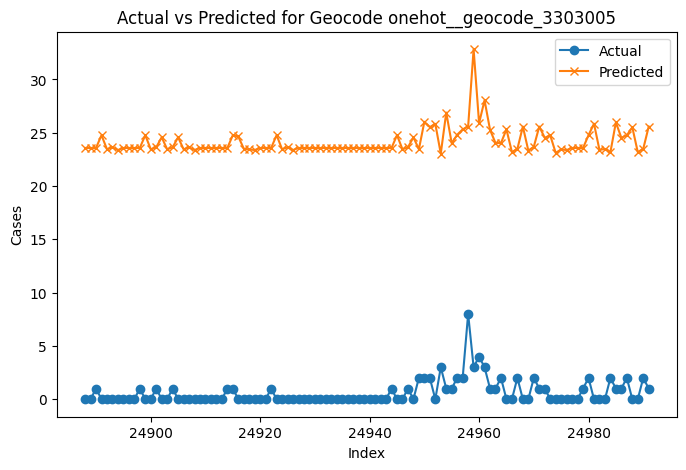

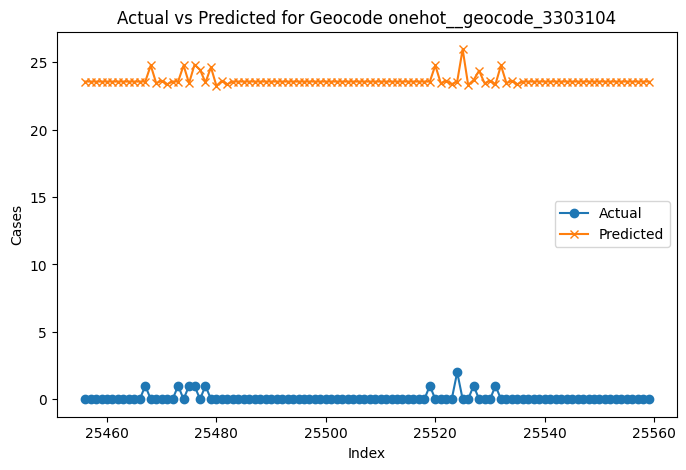

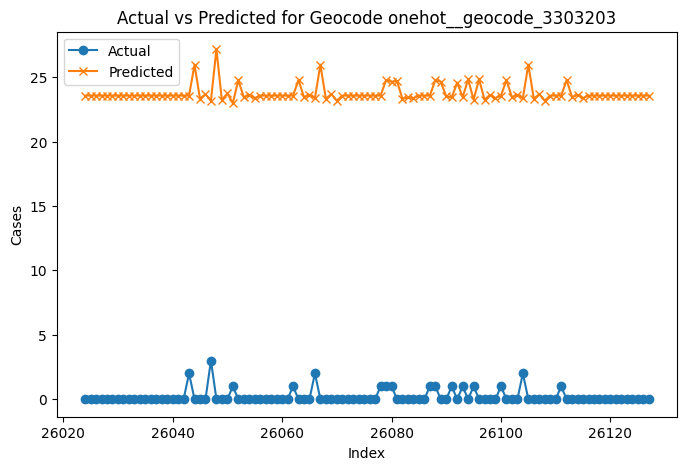

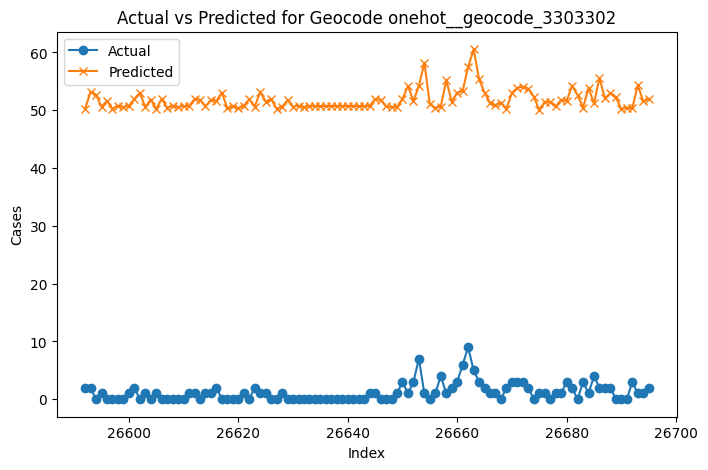

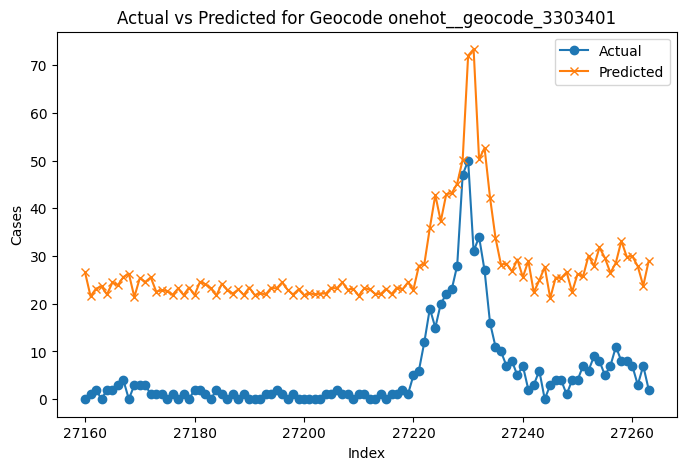

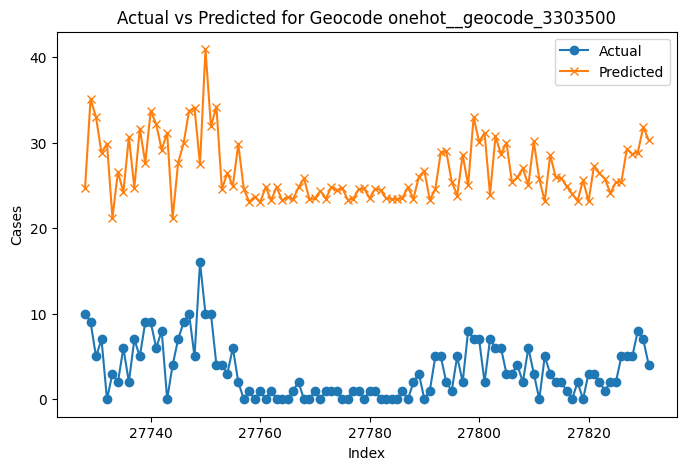

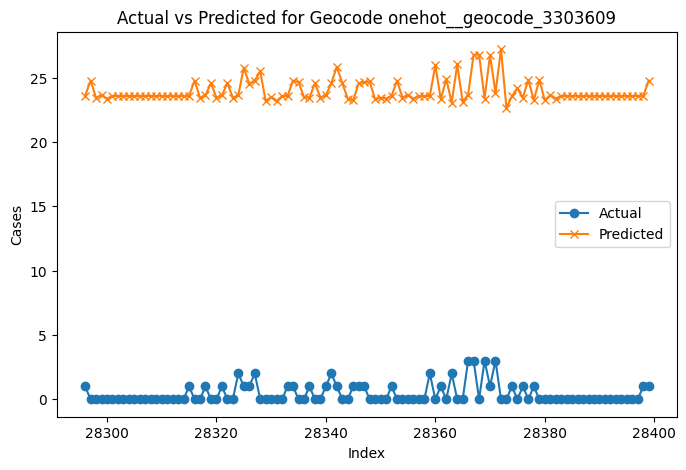

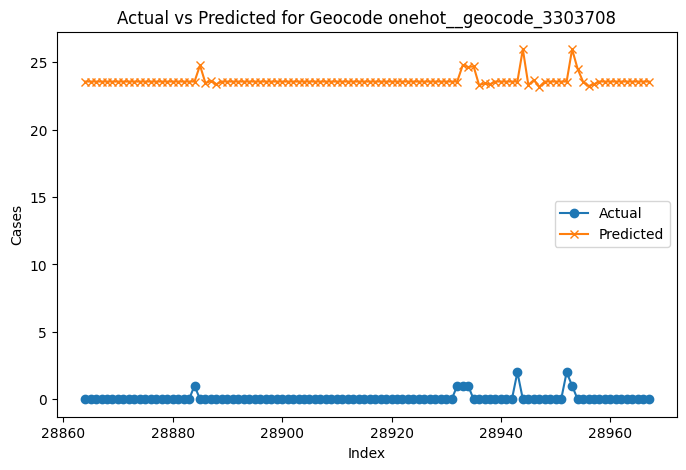

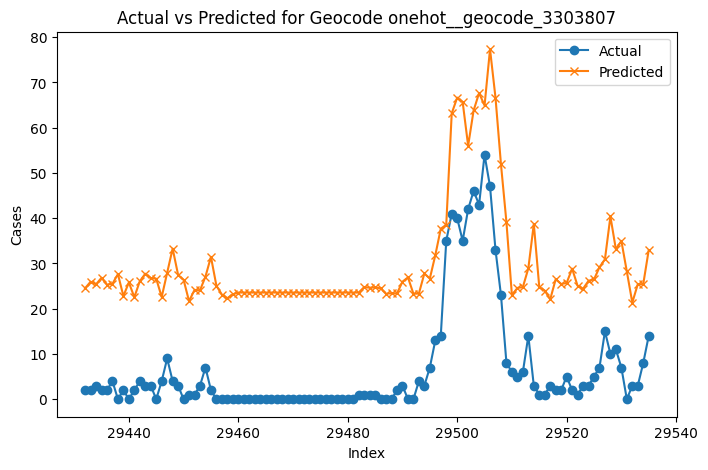

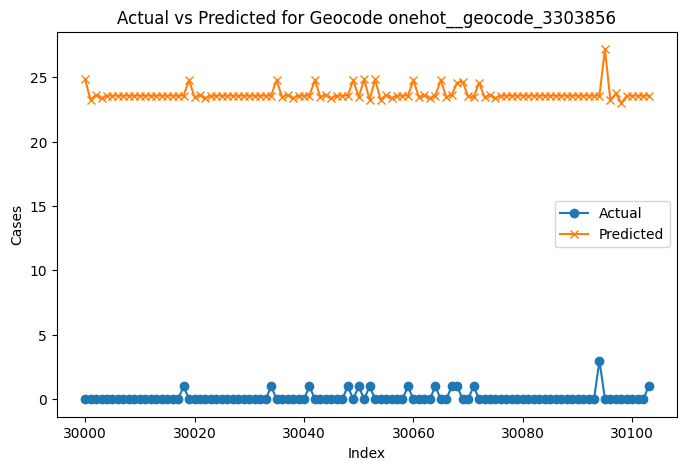

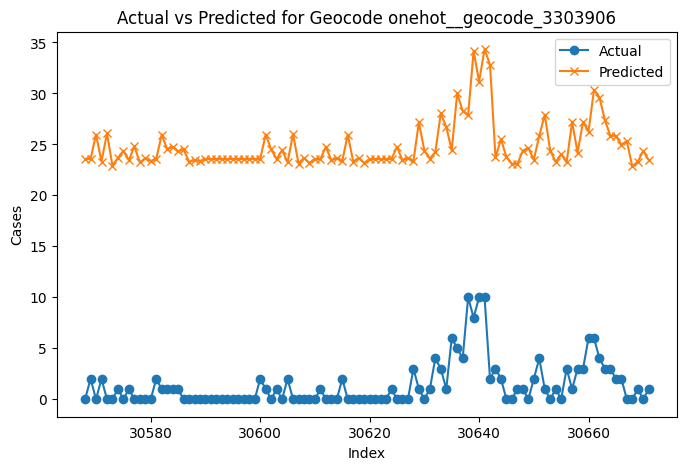

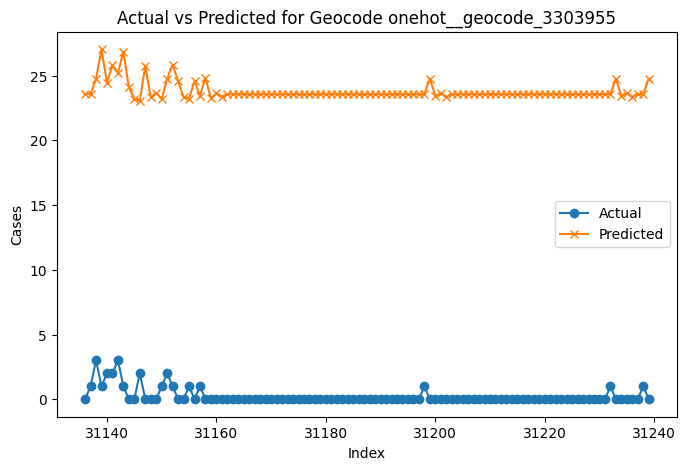

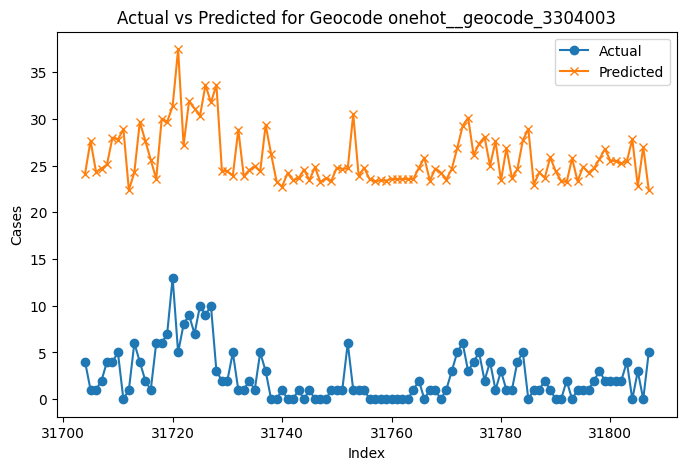

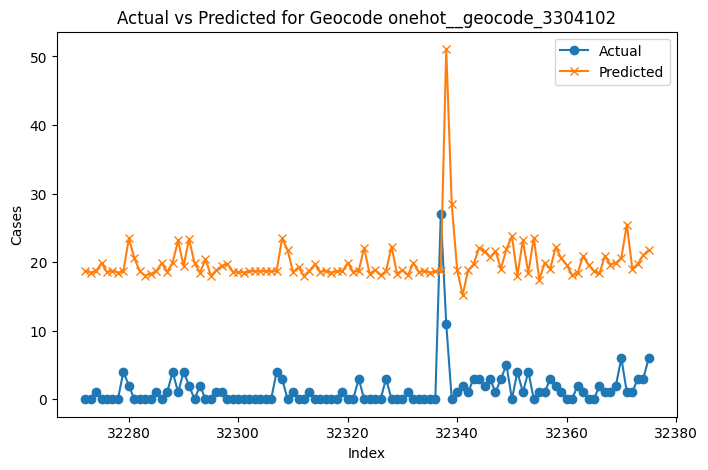

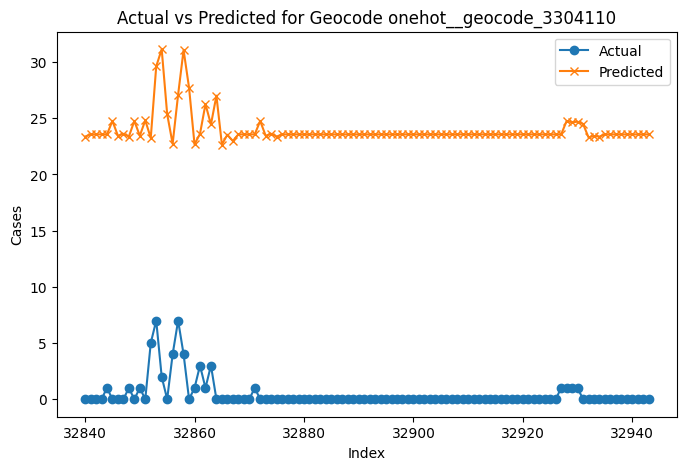

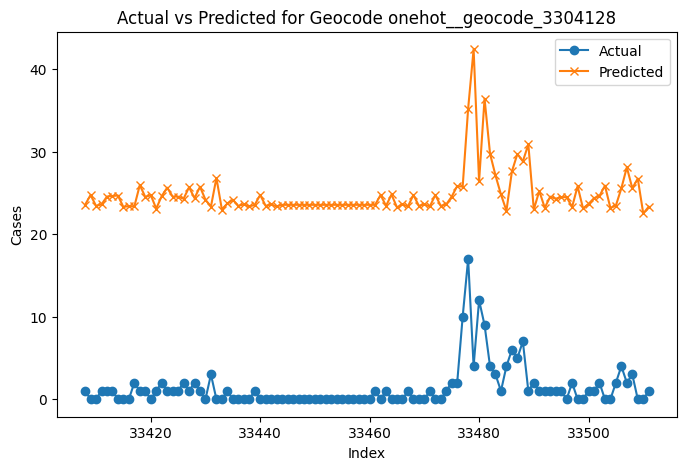

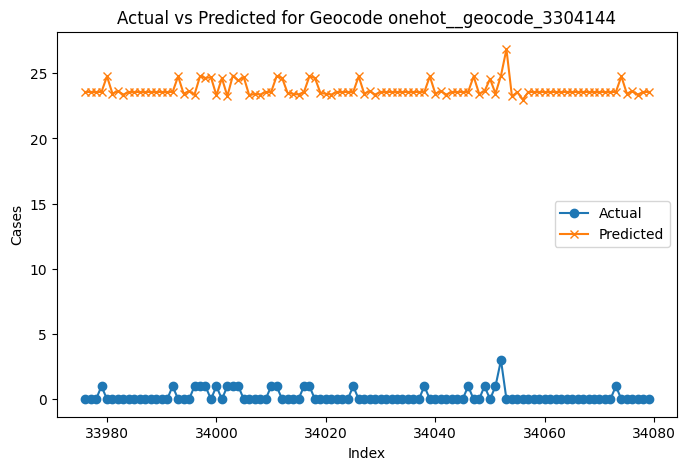

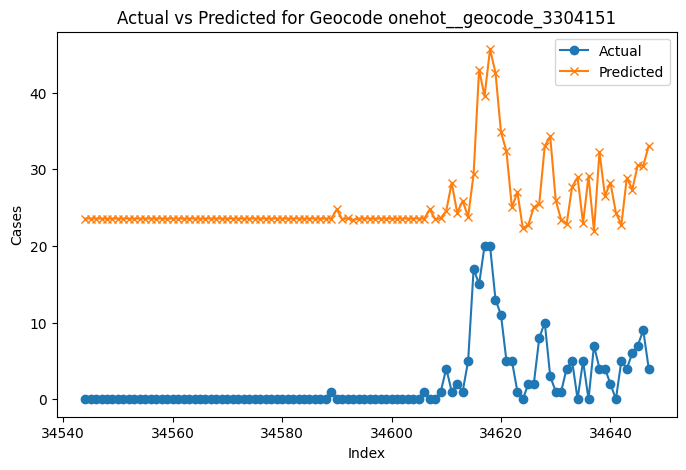

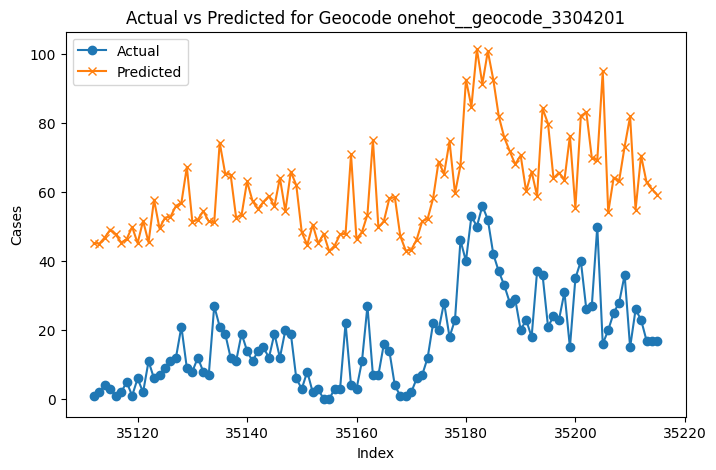

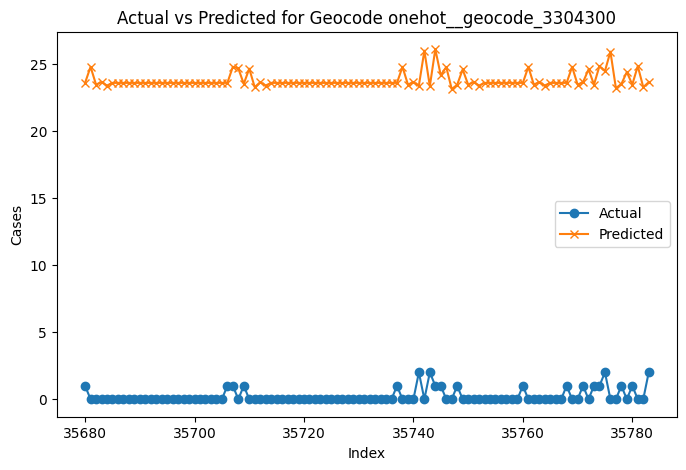

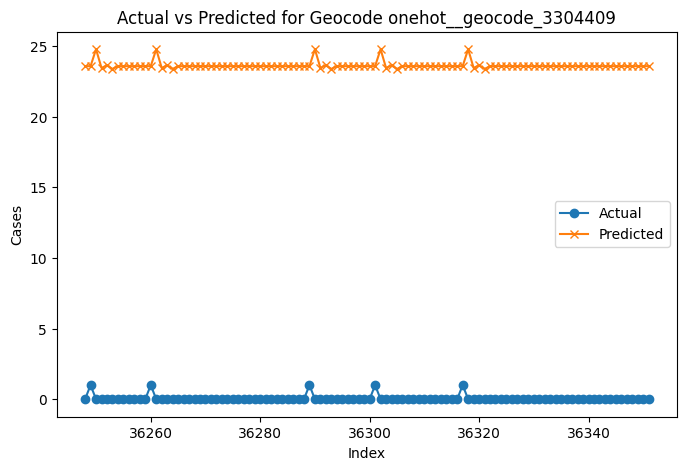

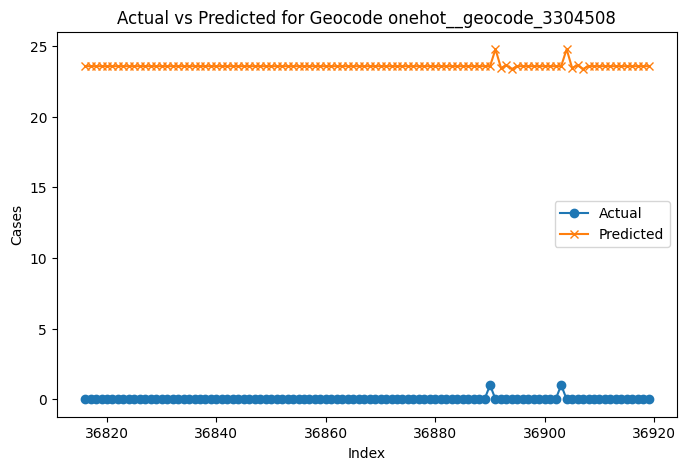

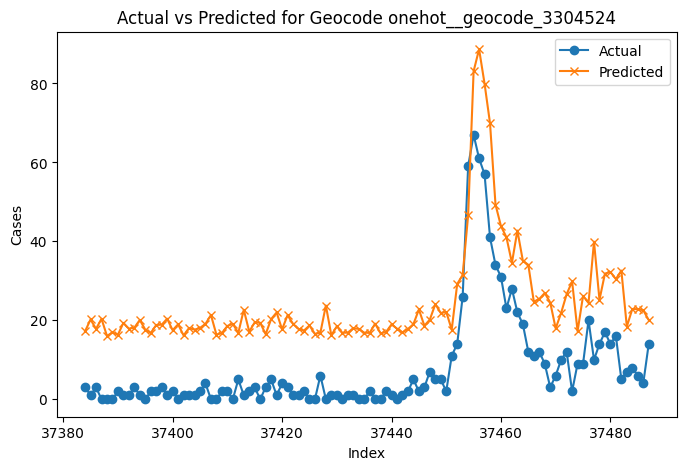

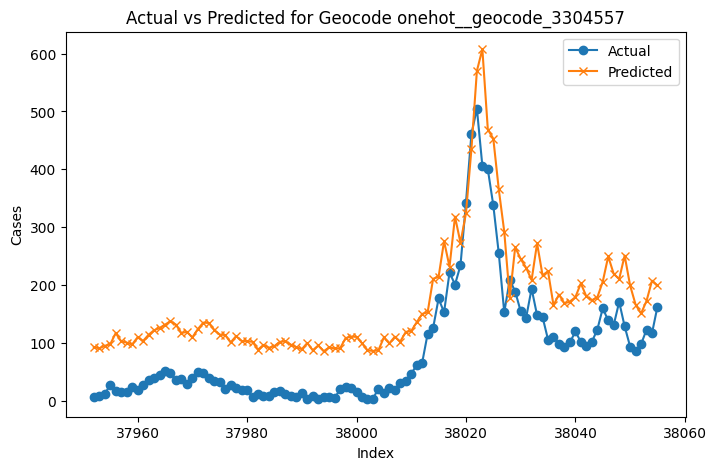

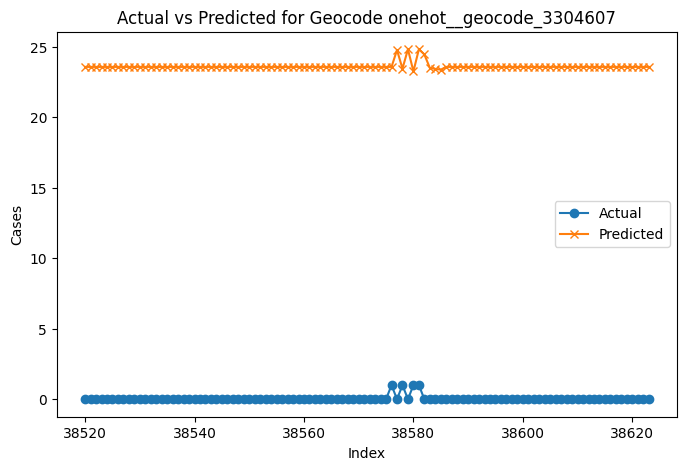

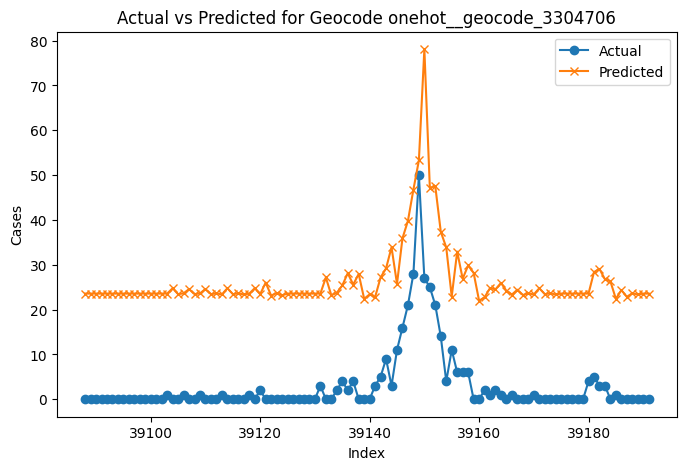

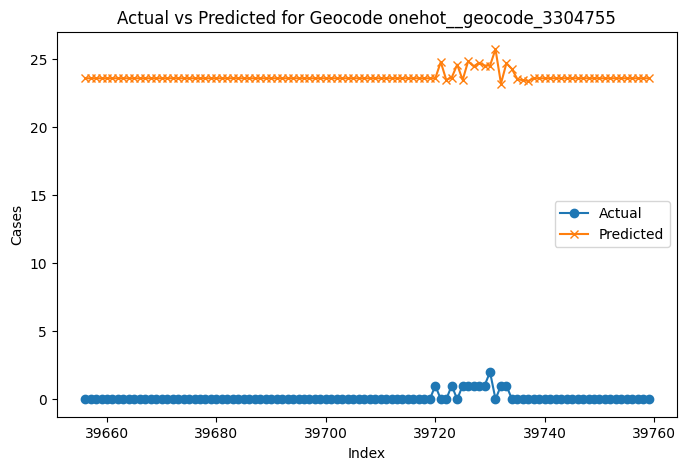

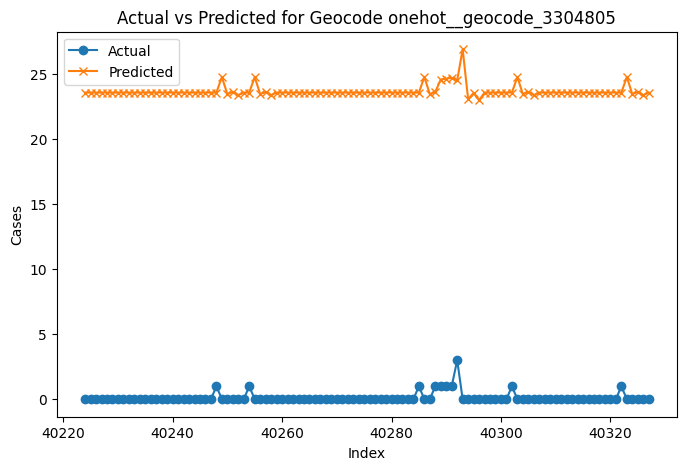

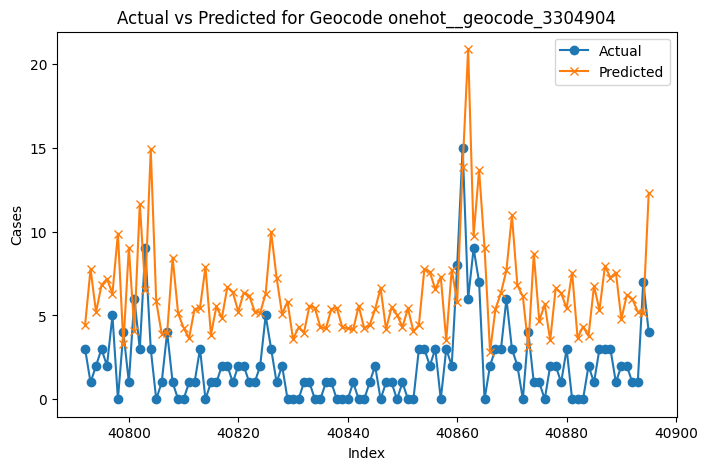

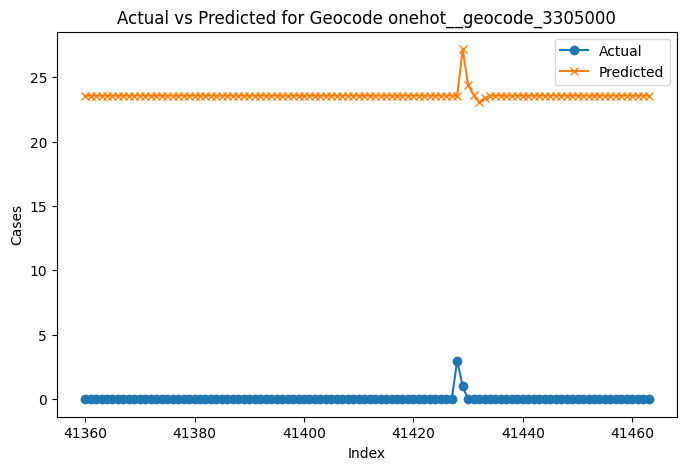

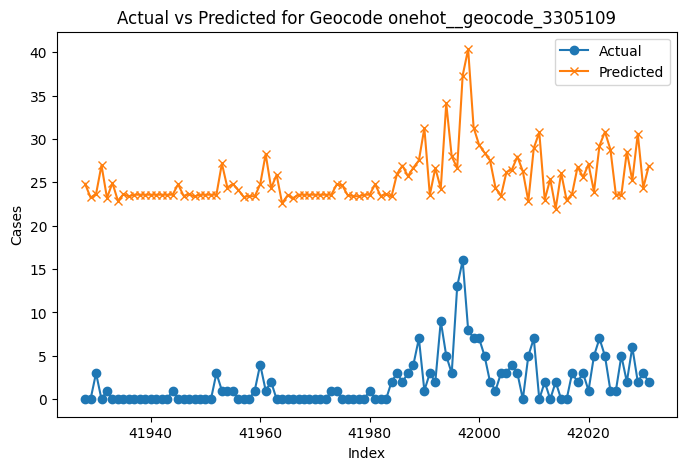

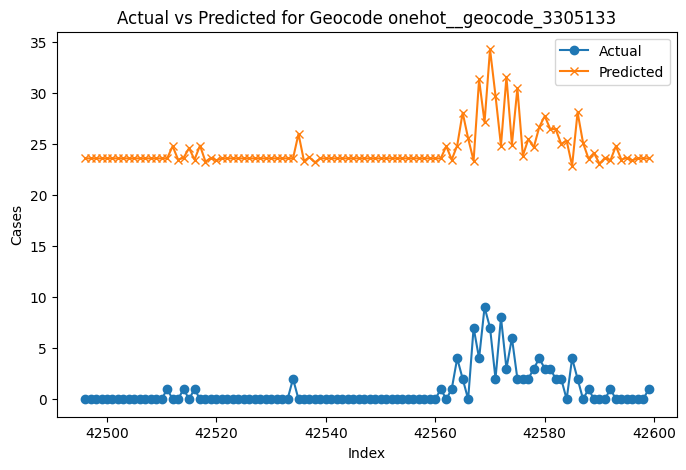

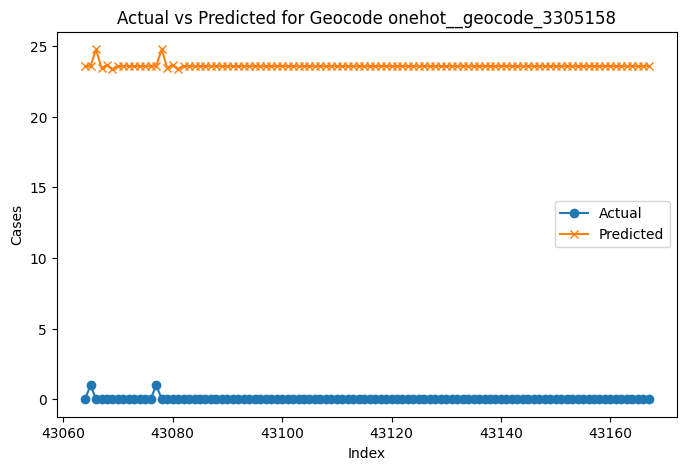

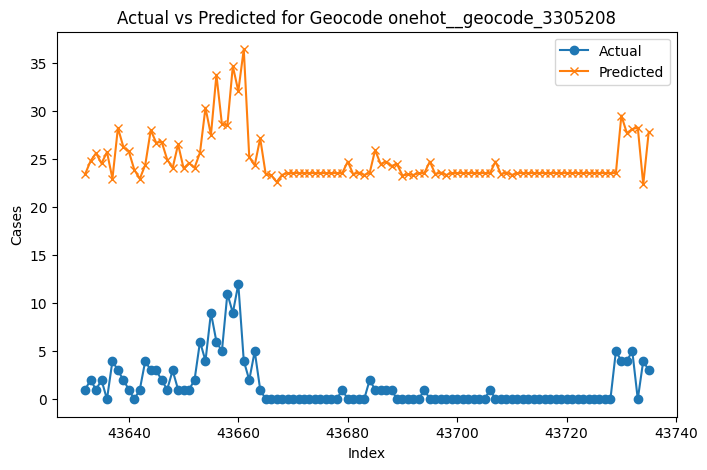

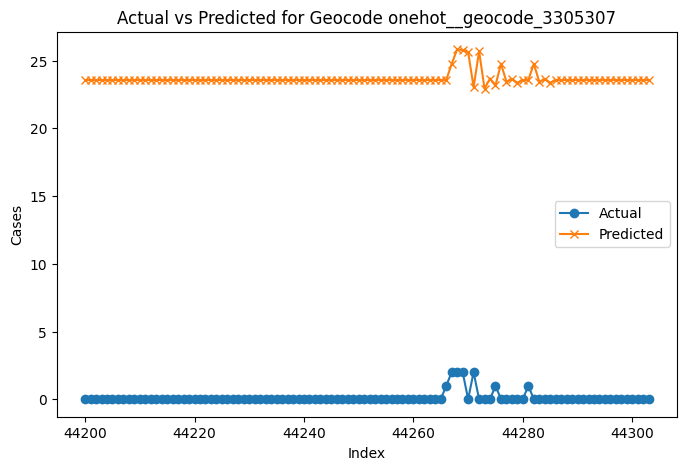

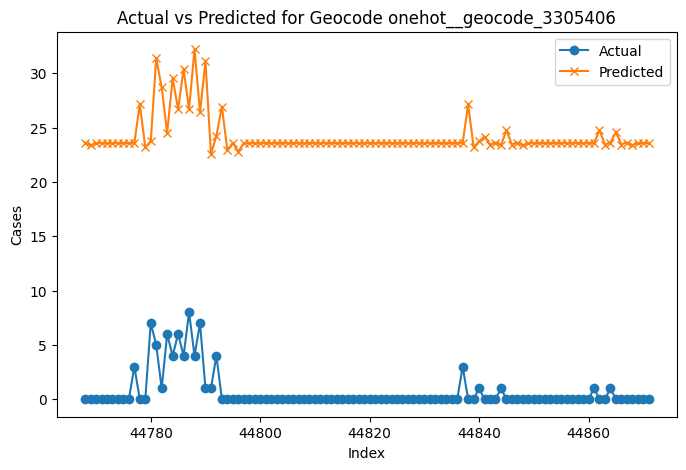

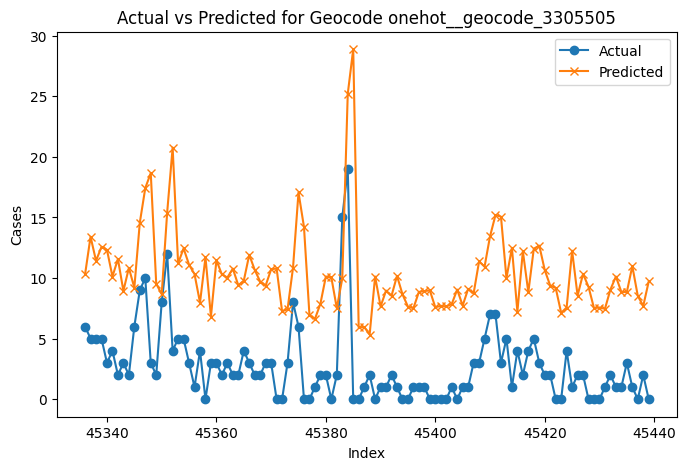

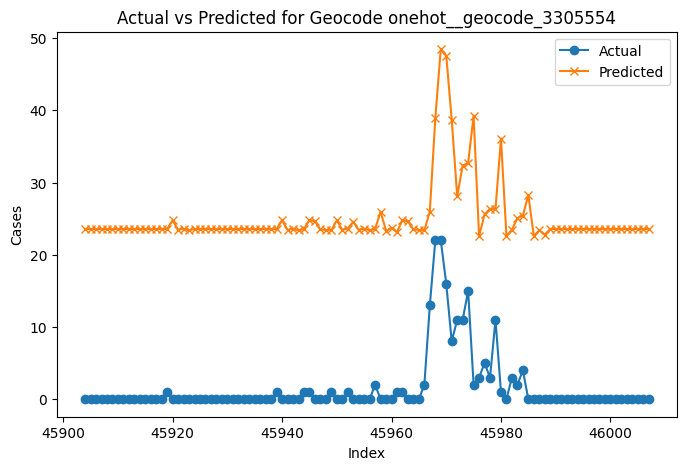

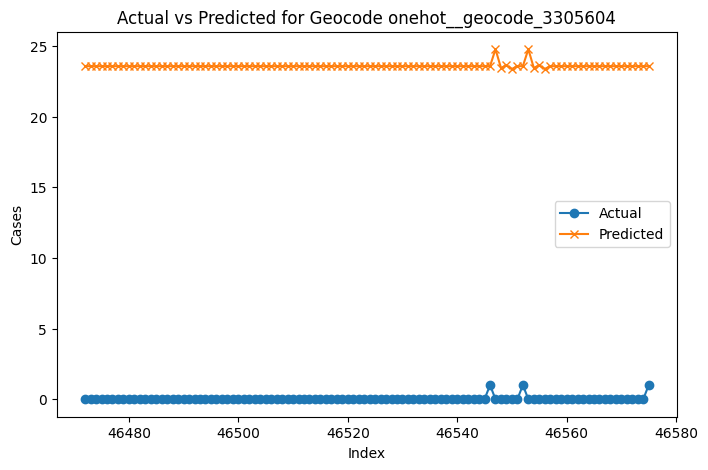

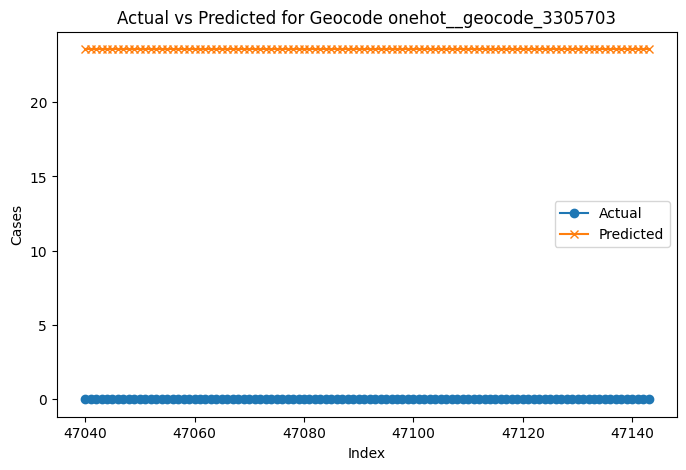

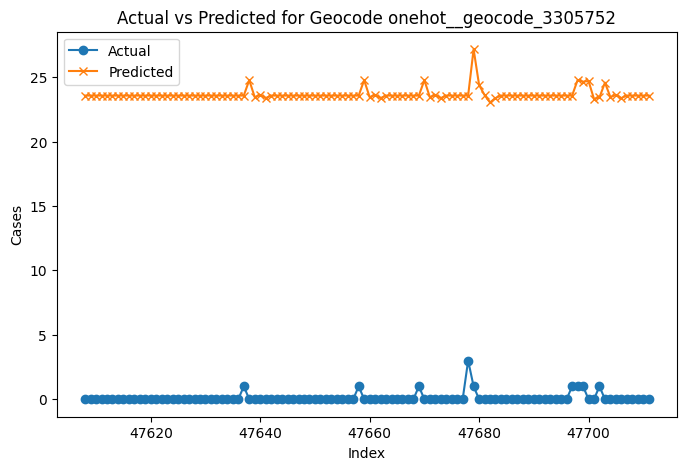

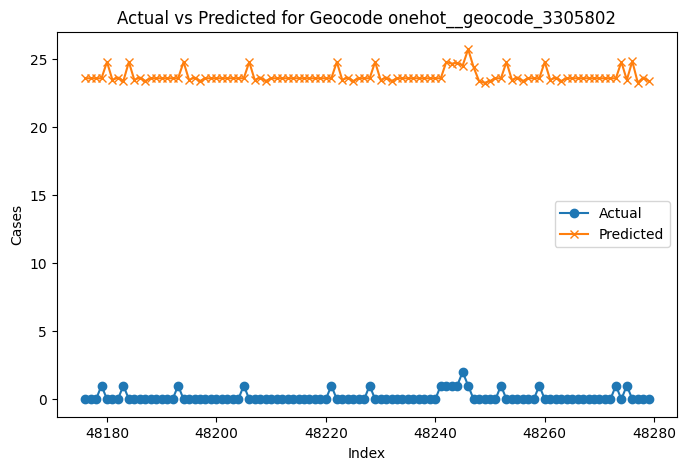

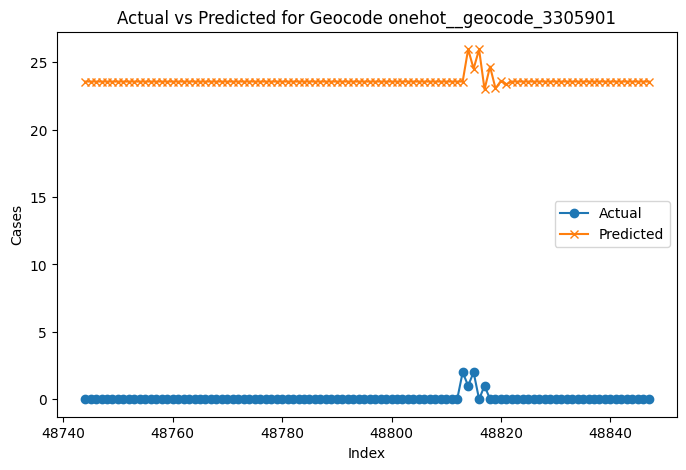

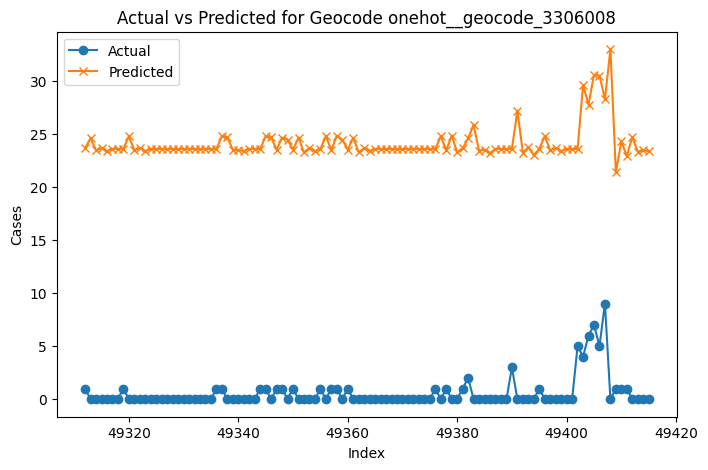

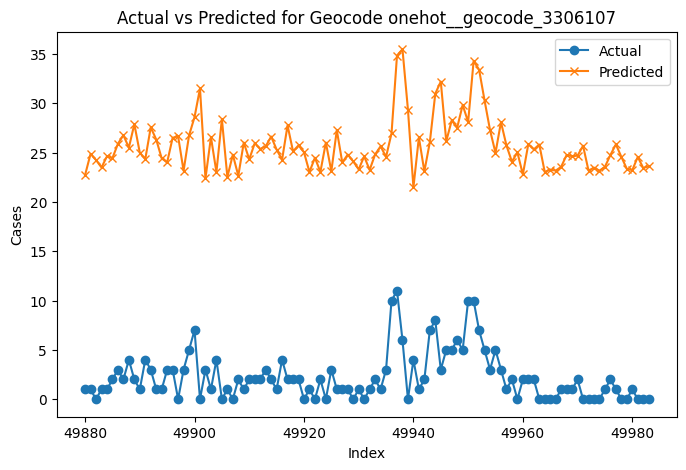

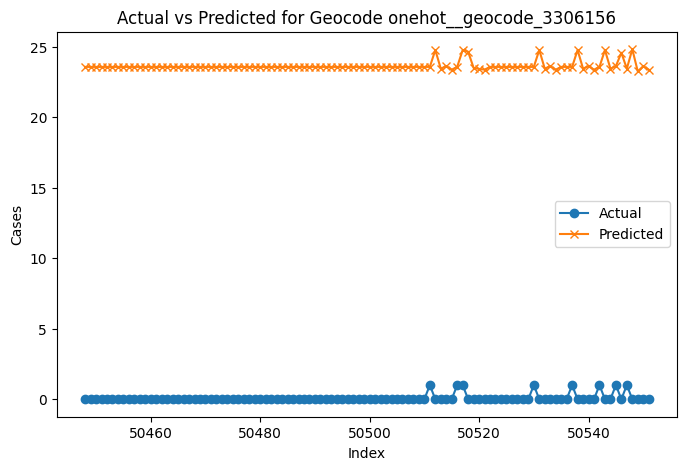

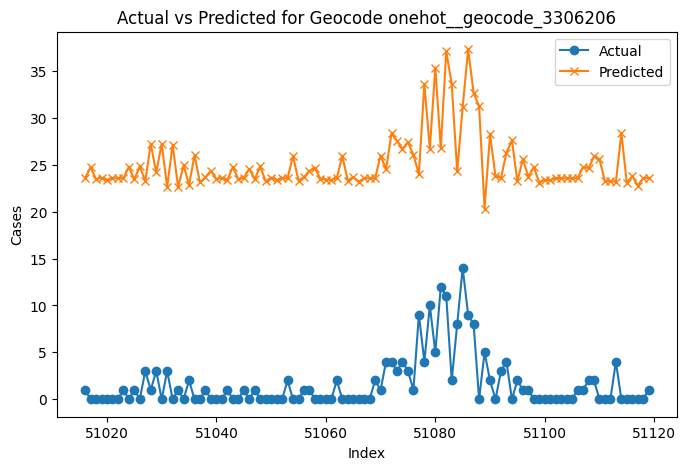

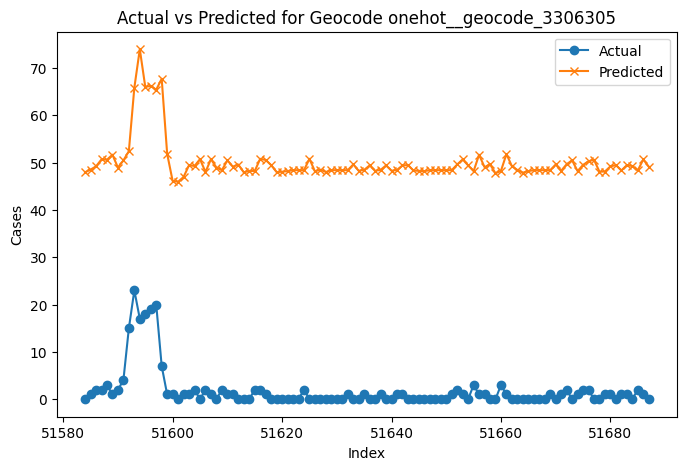

Best SVR Parameters: {'C': 10, 'gamma': 0.001, 'epsilon': 0.01, 'kernel': 'linear'}
Best Root Mean Squared Error (RMSE): 25.98782400208109
Mean Absolute Error (MAE): 23.77946794295575
Mean Absolute Percentage Error (MAPE): 6.78749843103874e+18 %


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Step 1-6: Keep the previous preprocessing steps the same (data preparation, scaling, etc.)
# Step 1: Define which columns to scale
columns_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                    'geocode', 'year_sin', 'year_cos'] + [col for col in data.columns if col.startswith('onehot__geocode_')]

# Step 2: Define which features you'll actually use for modeling
feature_cols = [
    'cases_lag1', 'cases_lag2', 'cases_lag3', 'cases_lag4',
    # Uncomment these if you want to use them
    # 'temp_avg_lag4', 'humidity_avg_lag4',
    # 'precipitation_max_regression_kriging_lag4',
    # 'week_sin', 'month_sin', 'week_cos', 'month_cos',
    # 'year_sin', 'year_cos'
]

# Add one-hot encoded columns
selected_columns = feature_cols + [col for col in data.columns if col.startswith('onehot_')]

# Step 3: Prepare feature matrix with only selected columns
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

# Step 4: Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Step 5: Scale features - only scale numeric features within selected_columns
numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and not col.startswith('onehot_')]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

# Step 6: Scale target variable (ensuring proper shape)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

# Store best model and its performance
best_model = None
best_rmse = float('inf')
best_params = None

# Parameter combinations
C_values = [0.1, 1, 10, 50]
gamma_values = [0.001, 0.01, 0.1, 0.5, 1]
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.5]
kernels = ["rbf", "linear", "poly"]

# Iterate through parameter combinations
for C in C_values:
    for gamma in gamma_values:
        for epsilon in epsilon_values:
            for kernel in kernels:
                # Skip degree parameter for non-poly kernels
                if kernel == "poly":
                    degrees = [2, 3, 4]
                else:
                    degrees = [None]
                
                for degree in degrees:
                    # Create SVR model with current parameters
                    svr_params = {
                        'C': C,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'kernel': kernel
                    }
                    
                    # Add degree only for poly kernel
                    if kernel == "poly" and degree is not None:
                        svr_params['degree'] = degree
                    
                    # Initialize and train the model
                    svr = SVR(**svr_params)
                    svr.fit(X_train, y_train_scaled)
                    
                    # Predict and calculate Root Mean Squared Error
                    y_pred_scaled = svr.predict(X_test)
                    
                    # Inverse transform predictions
                    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
                    y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
                    
                    # Calculate Root Mean Squared Error
                    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
                    print(f"Kernel: {kernel}, C: {C}, Gamma: {gamma}, Epsilon: {epsilon}" + 
                          (f", Degree: {degree}" if kernel == "poly" and degree is not None else "") + 
                          f", RMSE: {rmse:.4f}")                    # Update best model if current model performs better
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_model = svr
                        best_params = svr_params

# Final predictions using best model
y_pred_scaled = best_model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Prepare test dataframe with results
X_test_df = pd.DataFrame(X_test, columns=selected_columns)
X_test_df["actual"] = y_test_original
X_test_df["predicted"] = y_pred

# Plot Actual vs Predicted for each one-hot encoded geocode column
for geocode in X_test_df.columns:
    if geocode.startswith('onehot__geocode_'):
        # Filter the subset for rows where the current geocode column is 1
        subset = X_test_df[X_test_df[geocode] == 1]
        
        # Plot actual vs predicted cases
        plt.figure(figsize=(12, 6))
        plt.plot(subset.index, subset["actual"], label='Actual')
        plt.plot(subset.index, subset["predicted"], label='Predicted')
        plt.xlabel("Index")
        plt.ylabel("Cases")
        plt.title(f"Actual vs Predicted for Geocode {geocode}")
        plt.legend()
        plt.show()

# Print best SVR parameters and performance
print("Best SVR Parameters:", best_params)
print("Best Root Mean Squared Error (RMSE):", best_rmse)

# Additional performance metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100, "%")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
# Step 1: Define which columns to scale
columns_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                    'geocode', 'year_sin', 'year_cos'] + [col for col in data.columns if col.startswith('onehot__geocode_')]

# Step 2: Define which features you'll actually use for modeling
feature_cols = [
    'cases_lag1', 'cases_lag2', 'cases_lag3', 'cases_lag4',
    # Uncomment these if you want to use them
    # 'temp_avg_lag4', 'humidity_avg_lag4',
    # 'precipitation_max_regression_kriging_lag4',
    # 'week_sin', 'month_sin', 'week_cos', 'month_cos',
    # 'year_sin', 'year_cos'
]

# Add one-hot encoded columns
selected_columns = feature_cols + [col for col in data.columns if col.startswith('onehot_')]

# Step 3: Prepare feature matrix with only selected columns
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

# Step 4: Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Step 5: Scale features - only scale numeric features within selected_columns
numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and not col.startswith('onehot_')]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

# Step 6: Scale target variable (ensuring proper shape)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

# Step 7: Train model with grid search
param_grid = {
    "C": [0.1, 1, 10, 50, 100],  # Added higher C values for more complex patterns
    "gamma": [0.001, 0.01, 0.1, 0.5, 1, "scale", "auto"],  # Wider range of gamma values
    "epsilon": [0.01, 0.05, 0.1, 0.2, 0.5],  # More granular epsilon values
    "kernel": ["rbf", "linear", "poly", "sigmoid"]  # Try different kernels
}

# For polynomial kernel, you might want to add
if "poly" in param_grid["kernel"]:
    param_grid["degree"] = [2, 3, 4]  # Only relevant for poly kernel

svr = SVR()
grid_search = GridSearchCV(
    svr, 
    param_grid,
    scoring="neg_mean_absolute_error",  # You could also try neg_root_mean_squared_error
    verbose=2, 
    n_jobs=-1,
    cv=3
)
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="neg_mean_absolute_error", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train_scaled)

# Step 8: Make predictions and inverse transform to original scale
best_svr = grid_search.best_estimator_
y_pred_scaled = best_svr.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
X_test_df = pd.DataFrame(X_test, columns=selected_columns)

# Add actual and predicted values
X_test_df["actual"] = y_test_original
X_test_df["predicted"] = y_pred

# Plot Actual vs Predicted for each geocode

# Plot Actual vs Predicted for each one-hot encoded geocode column
for geocode in X_test_df.columns:
    if geocode.startswith('onehot__geocode_'):  # Identify one-hot encoded geocode columns
        # Filter the subset for rows where the current geocode column is 1
        subset = X_test_df[X_test_df[geocode] == 1]
        
        # Plot actual vs predicted cases
        plt.figure(figsize=(8, 5))
        plt.plot(subset.index, subset["actual"], label='Actual', marker='o')
        plt.plot(subset.index, subset["predicted"], label='Predicted', marker='x')
        plt.xlabel("Index")
        plt.ylabel("Cases")
        plt.title(f"Actual vs Predicted for Geocode {geocode}")
        plt.legend()
        plt.show()

# Print best SVR parameters
print("Best SVR Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 2100 candidates, totalling 10500 fits


In [ ]:

columns_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week','lat','long','geocode','year_sin','year_cos'] + [col for col in data.columns if col.startswith('onehot__geocode_')]
numeric_cols = [
    col for col in data.select_dtypes(include=['float64', 'int64', 'int32','float32']).columns 
    if col not in ['cases'] + columns_to_scale]
# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the selected numeric features
X_train[numeric_cols] = feature_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = feature_scaler.transform(X_test[numeric_cols])

# Scale the target variable
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

feature_cols = [
    # 'temp_avg_lag4', 'humidity_avg_lag4', 
    'cases_lag1', 'cases_lag2',
    'cases_lag3','cases_lag4',
    # 'precipitation_max_regression_kriging_lag4'
    # , 'week_sin', 'month_sin', 
    # 'week_cos', 'month_cos',
    # 'year_sin','year_cos'
]



# Combine selected features and one-hot encoded columns
selected_columns = feature_cols  + [col for col in data.columns if col.startswith('onehot_')]

# Filter the dataset to keep only these columns
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

In [18]:
X_train

cases_lag1  cases_lag2  cases_lag3  cases_lag4 onehot__geocode_3300100  \
0        0.002652    0.002448    0.002244    0.001292                     1.0   
1        0.002516    0.002652    0.002448    0.002244                     1.0   
2        0.002244    0.002516    0.002652    0.002448                     1.0   
3        0.003128    0.002244    0.002516    0.002652                     1.0   
4        0.002856    0.003128    0.002244    0.002516                     1.0   
...           ...         ...         ...         ...                     ...   
51579    0.000068    0.000000    0.000068    0.000136                     0.0   
51580    0.000204    0.000068    0.000000    0.000068                     0.0   
51581    0.000068    0.000204    0.000068    0.000000                     0.0   
51582    0.000000    0.000068    0.000204    0.000068                     0.0   
51583    0.000136    0.000000    0.000068    0.000204                     0.0   

      onehot__geocode_3300159 onehot__geocode_3300209 onehot__geocode_3300225  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51579                     0.0                     0.0                     0.0   
51580                     0.0                     0.0                     0.0   
51581                     0.0                     0.0                     0.0   
51582                     0.0                     0.0                     0.0   
51583                     0.0                     0.0                     0.0   

      onehot__geocode_3300233 onehot__geocode_3300258  ...  \
0                         0.0                     0.0  ...   
1                         0.0                     0.0  ...   
2                         0.0                     0.0  ...   
3                         0.0                     0.0  ...   
4                         0.0                     0.0  ...   
...                       ...                     ...  ...   
51579                     0.0                     0.0  ...   
51580                     0.0                     0.0  ...   
51581                     0.0                     0.0  ...   
51582                     0.0                     0.0  ...   
51583                     0.0                     0.0  ...   

      onehot__geocode_3305604 onehot__geocode_3305703 onehot__geocode_3305752  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51579                     0.0                     0.0                     0.0   
51580                     0.0                     0.0                     0.0   
51581                     0.0                     0.0                     0.0   
51582                     0.0                     0.0                     0.0   
51583                     0.0                     0.0                     0.0   

      onehot__geocode_3305802 onehot__geocode_3305901 onehot__geocode_3306008  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                  

In [19]:
X_test

cases_lag1  cases_lag2  cases_lag3  cases_lag4 onehot__geocode_3300100  \
464      0.000000    0.000136    0.000136    0.000000                     1.0   
465      0.000068    0.000000    0.000136    0.000136                     1.0   
466      0.000000    0.000068    0.000000    0.000136                     1.0   
467      0.000000    0.000000    0.000068    0.000000                     1.0   
468      0.000000    0.000000    0.000000    0.000068                     1.0   
...           ...         ...         ...         ...                     ...   
51683    0.000068    0.000000    0.000068    0.000068                     0.0   
51684    0.000068    0.000068    0.000000    0.000068                     0.0   
51685    0.000000    0.000068    0.000068    0.000000                     0.0   
51686    0.000136    0.000000    0.000068    0.000068                     0.0   
51687    0.000068    0.000136    0.000000    0.000068                     0.0   

      onehot__geocode_3300159 onehot__geocode_3300209 onehot__geocode_3300225  \
464                       0.0                     0.0                     0.0   
465                       0.0                     0.0                     0.0   
466                       0.0                     0.0                     0.0   
467                       0.0                     0.0                     0.0   
468                       0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300233 onehot__geocode_3300258  ...  \
464                       0.0                     0.0  ...   
465                       0.0                     0.0  ...   
466                       0.0                     0.0  ...   
467                       0.0                     0.0  ...   
468                       0.0                     0.0  ...   
...                       ...                     ...  ...   
51683                     0.0                     0.0  ...   
51684                     0.0                     0.0  ...   
51685                     0.0                     0.0  ...   
51686                     0.0                     0.0  ...   
51687                     0.0                     0.0  ...   

      onehot__geocode_3305604 onehot__geocode_3305703 onehot__geocode_3305752  \
464                       0.0                     0.0                     0.0   
465                       0.0                     0.0                     0.0   
466                       0.0                     0.0                     0.0   
467                       0.0                     0.0                     0.0   
468                       0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3305802 onehot__geocode_3305901 onehot__geocode_3306008  \
464                       0.0                     0.0                     0.0   
465                       0.0                     0.0                     0.0   
466                       0.0                     0.0                     0.0   
467                

In [20]:
y_train

array([[0.00251564],
       [0.00224368],
       [0.00312755],
       ...,
       [0.        ],
       [0.00013598],
       [0.        ]])

In [21]:
y_test

array([[6.79902094e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       ...,
       [1.35980419e-04],
       [6.79902094e-05],
       [0.00000000e+00]])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


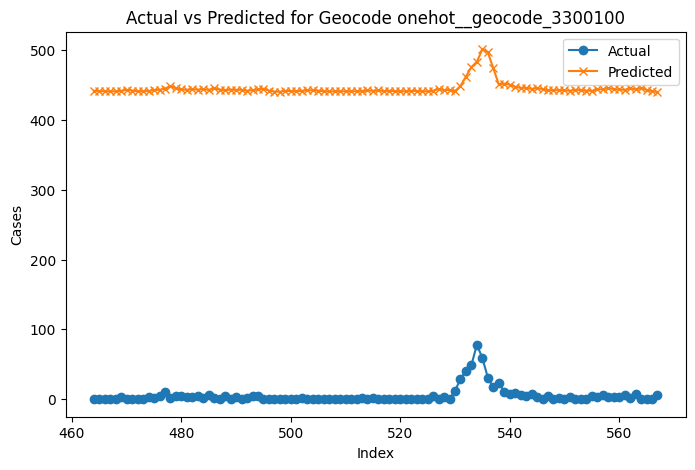

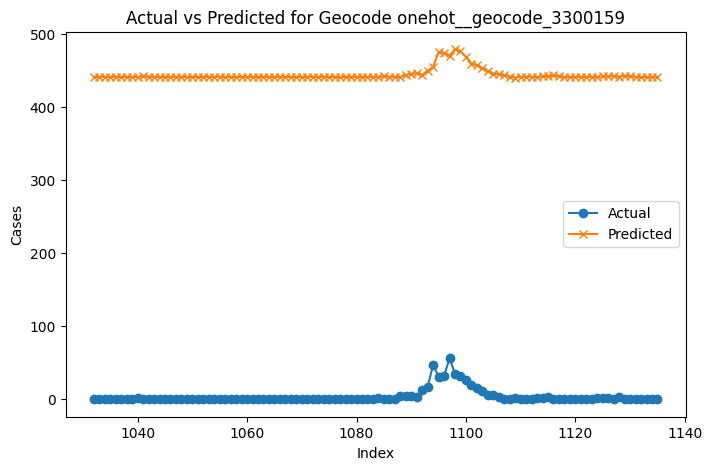

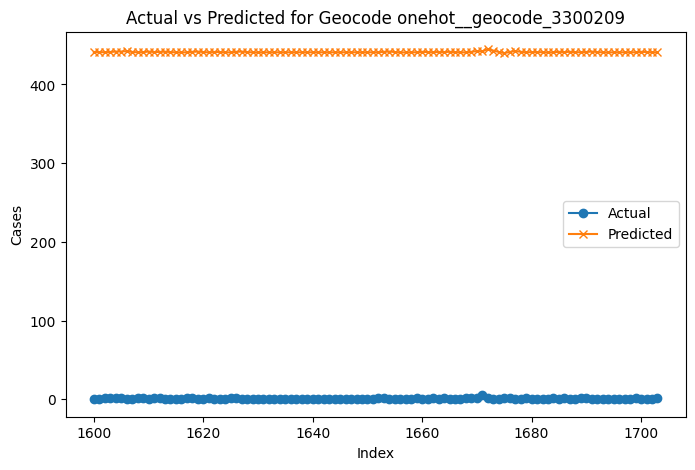

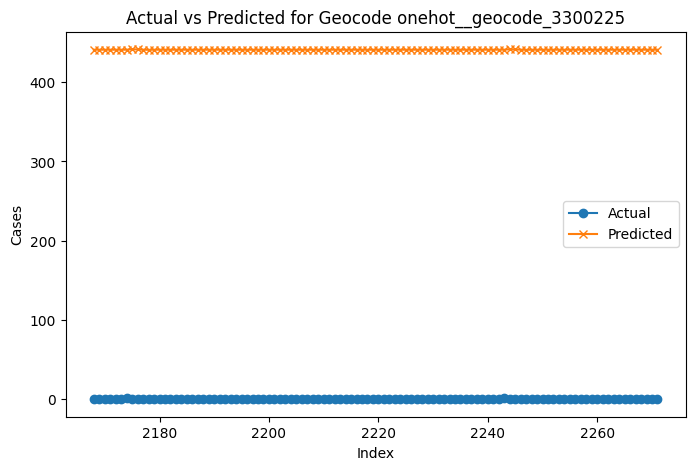

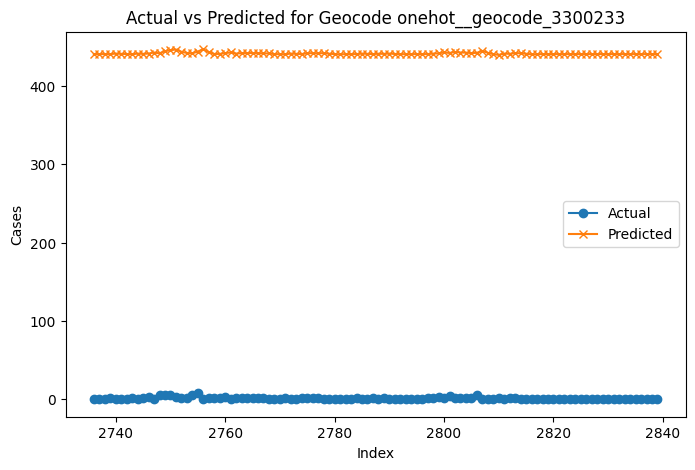

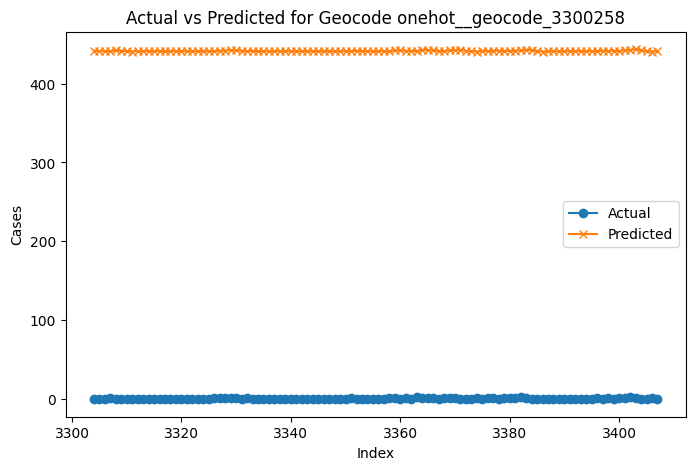

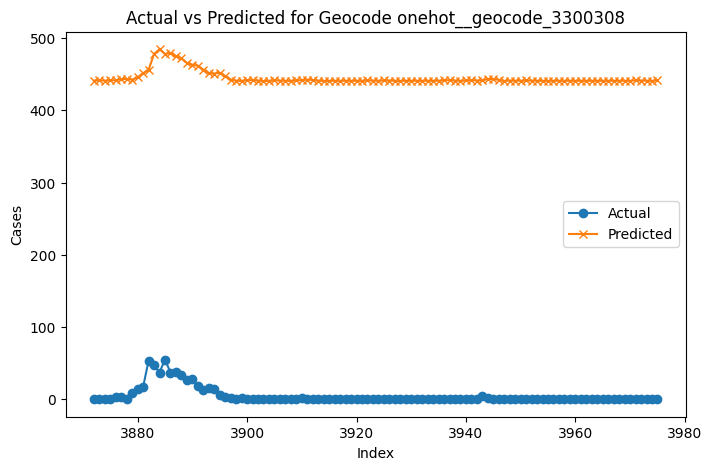

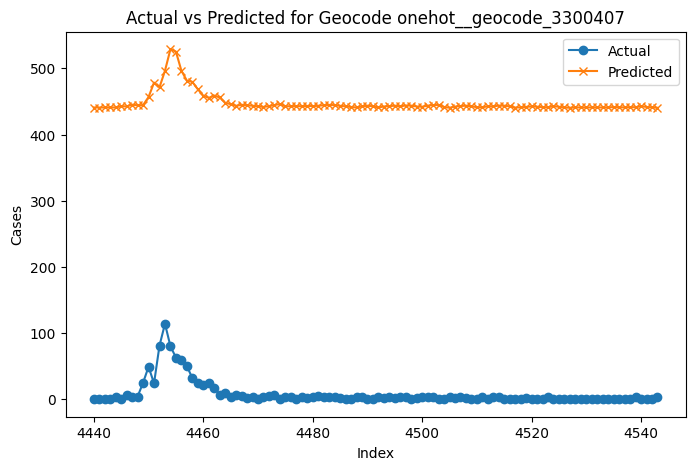

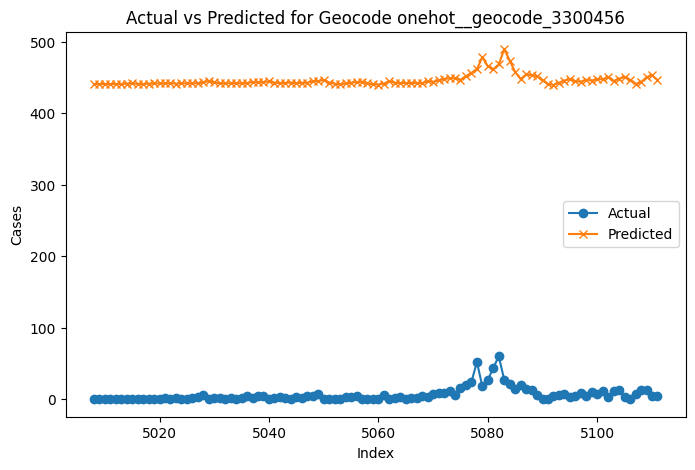

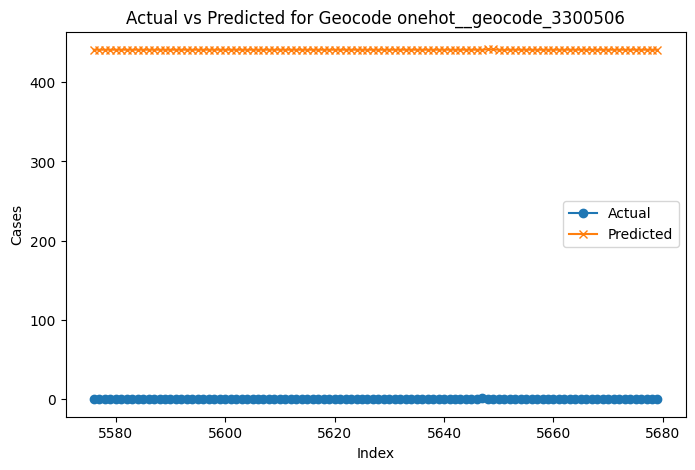

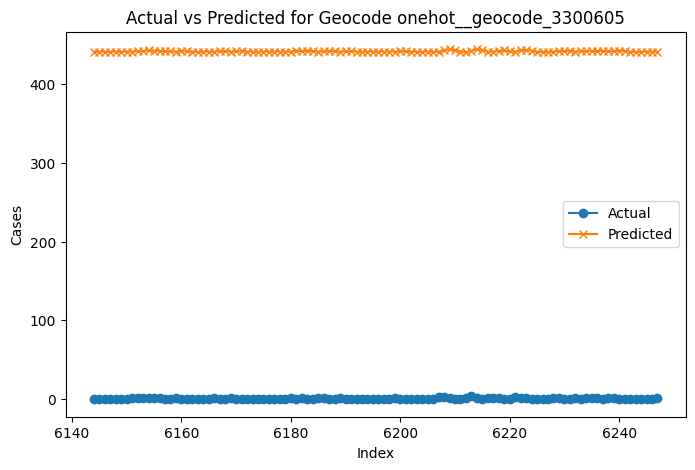

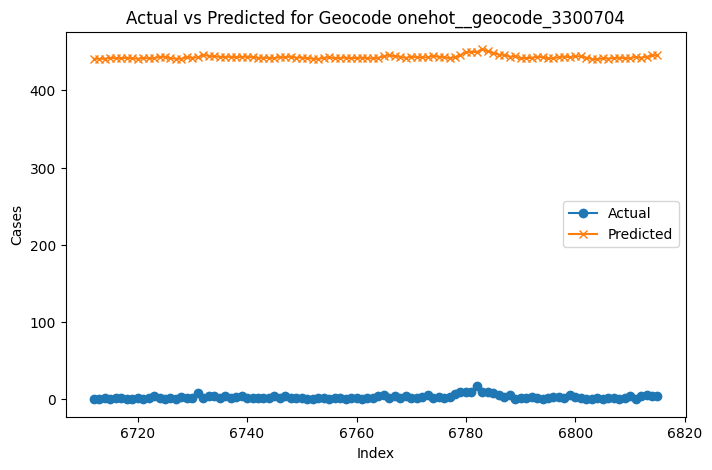

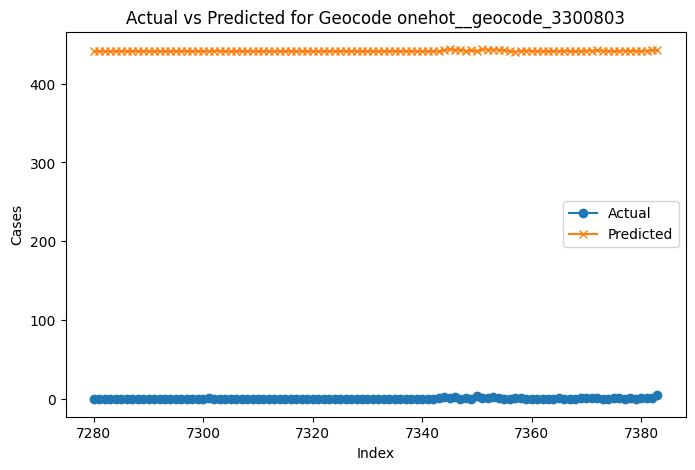

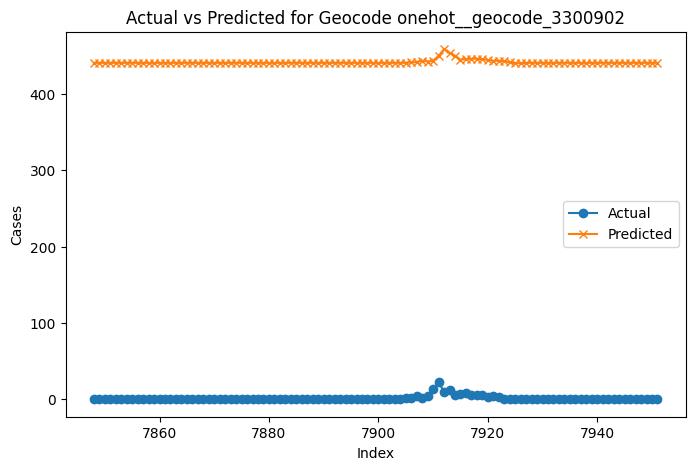

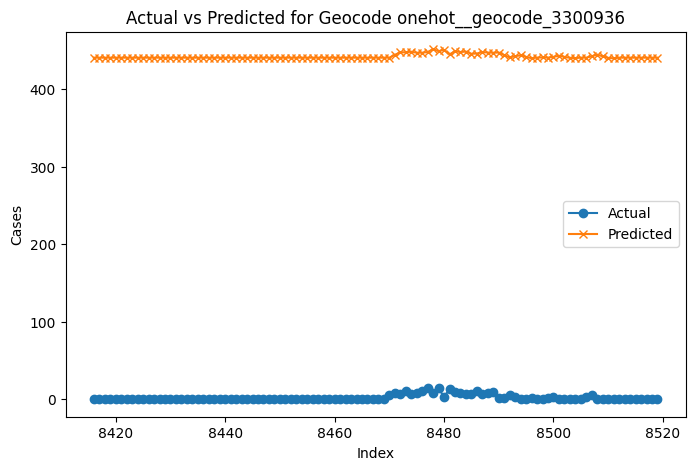

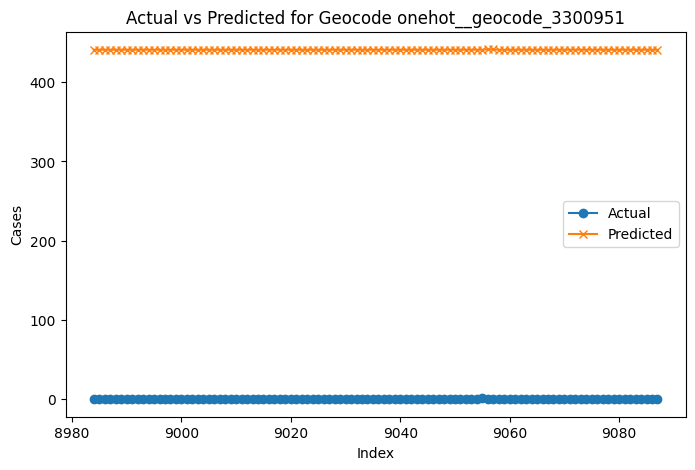

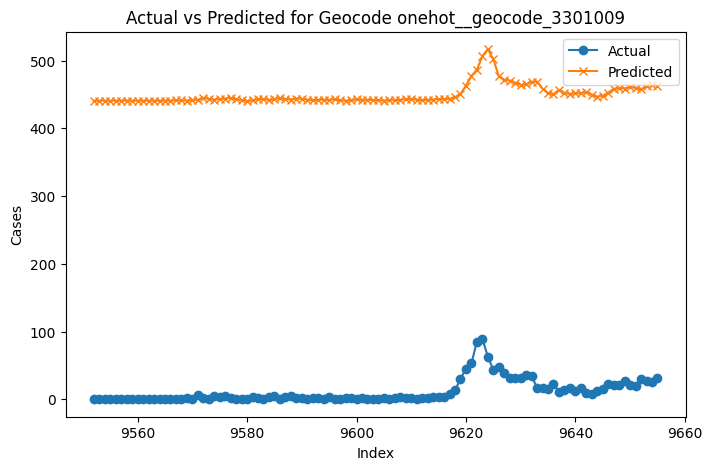

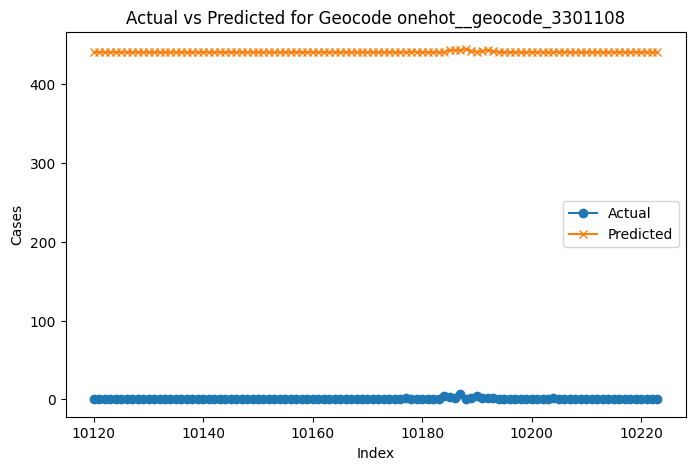

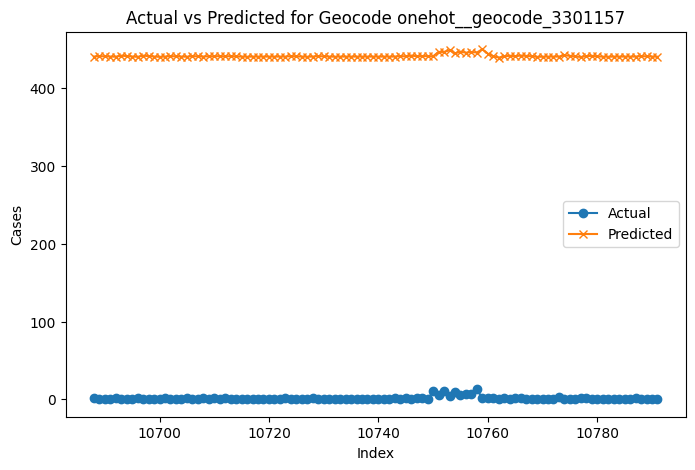

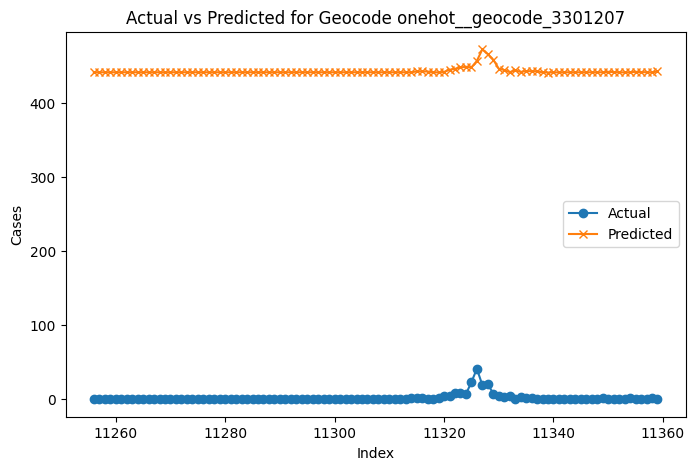

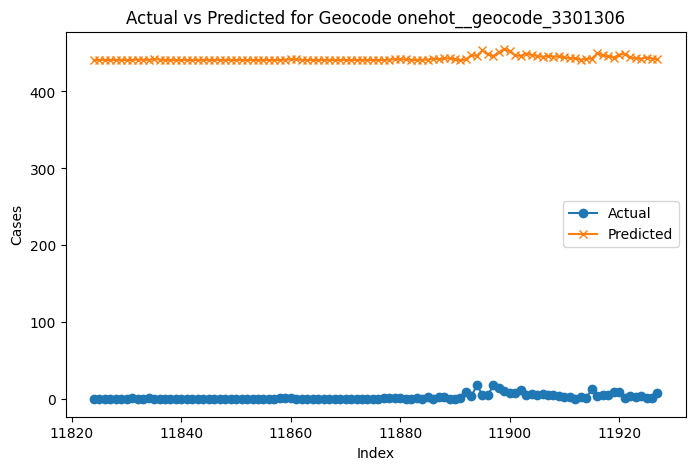

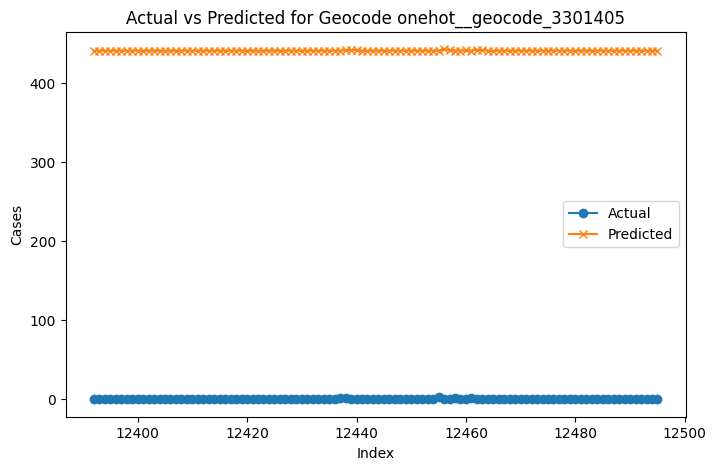

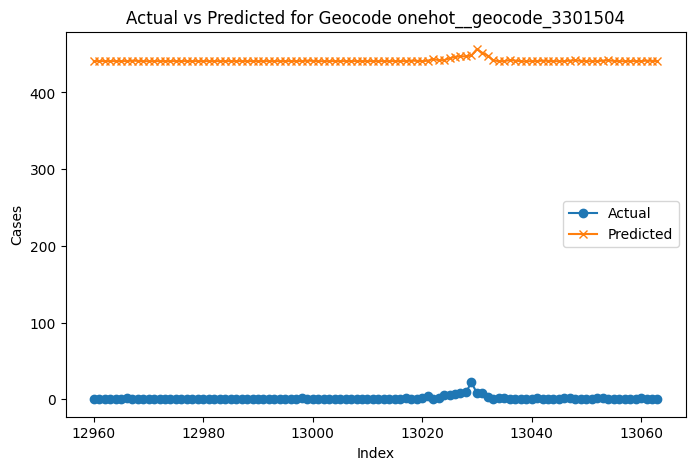

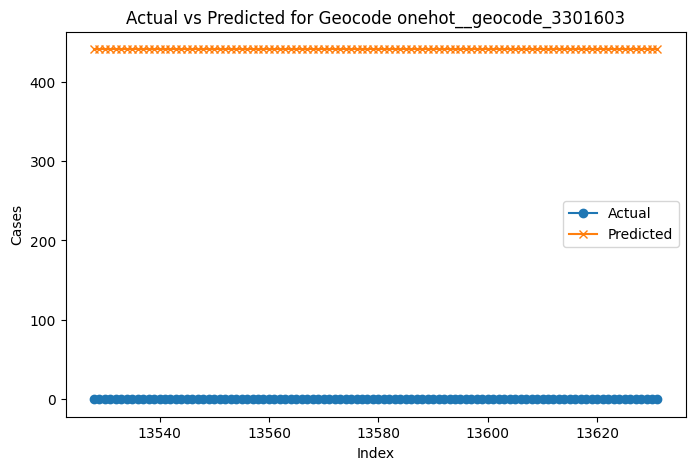

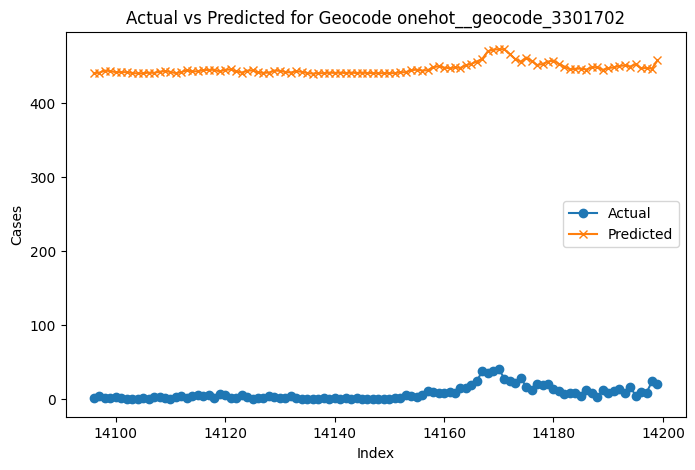

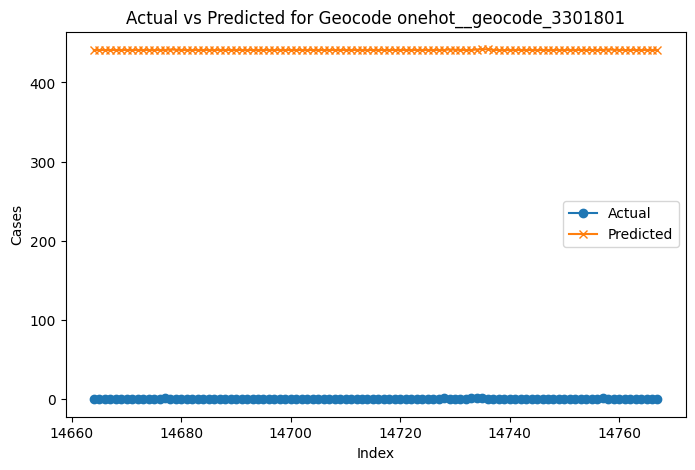

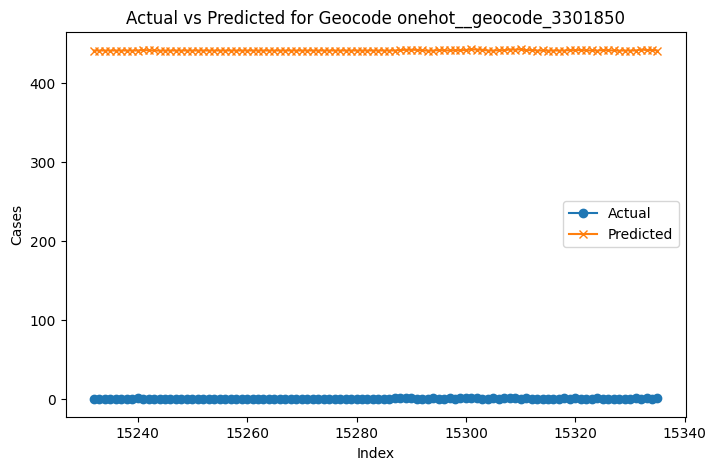

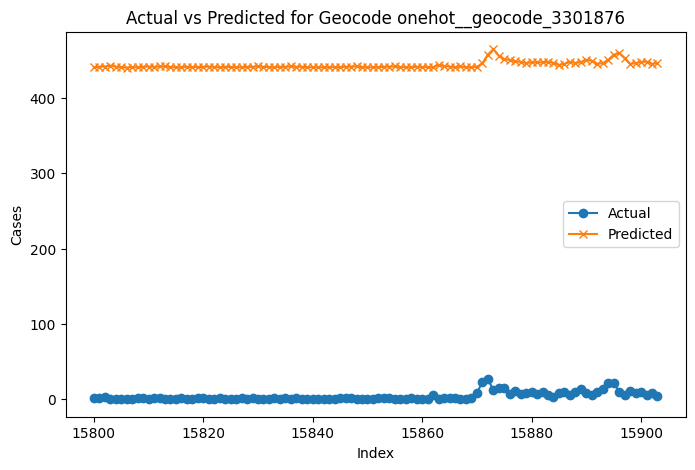

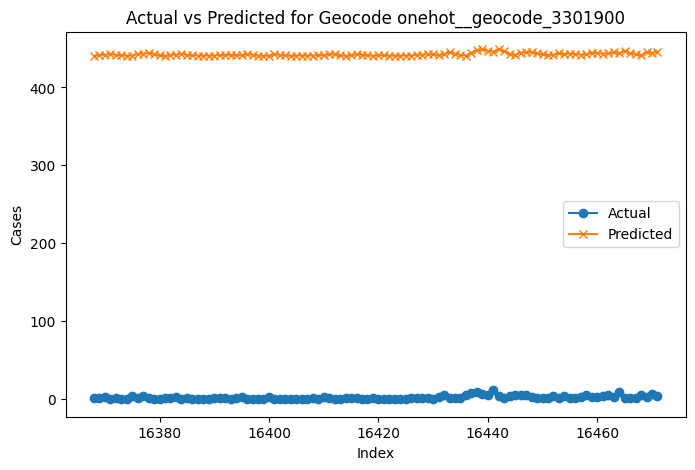

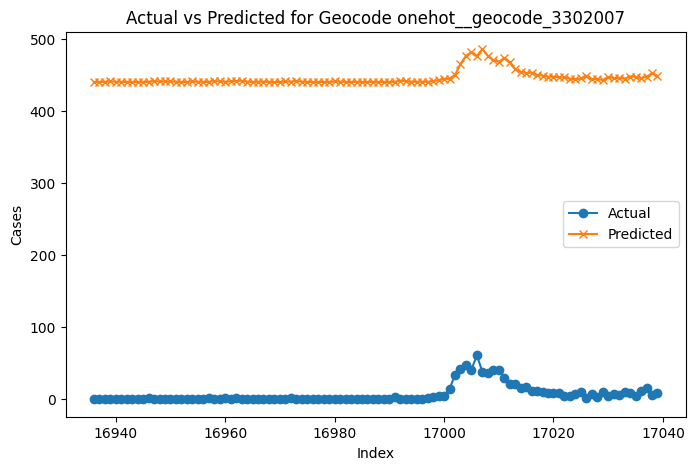

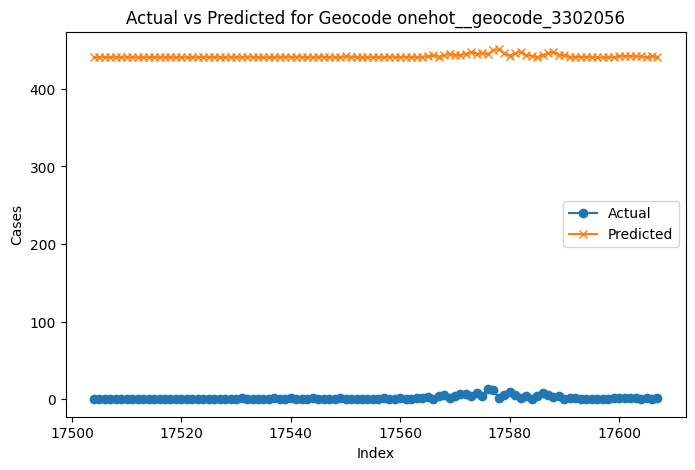

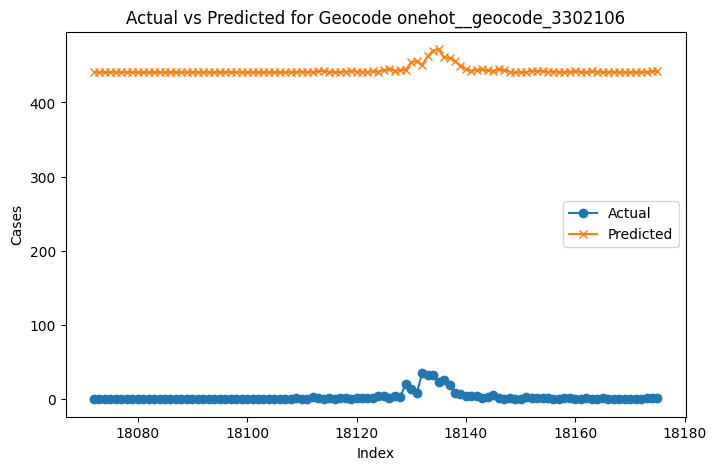

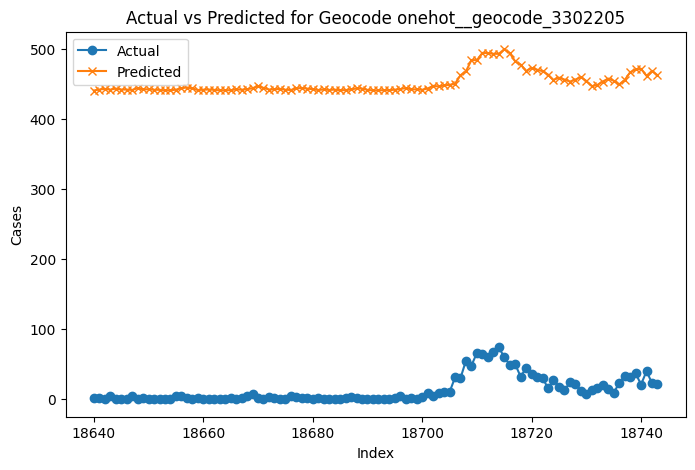

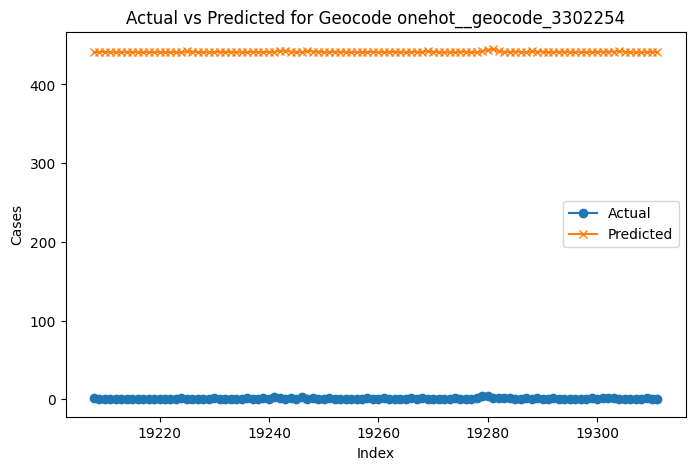

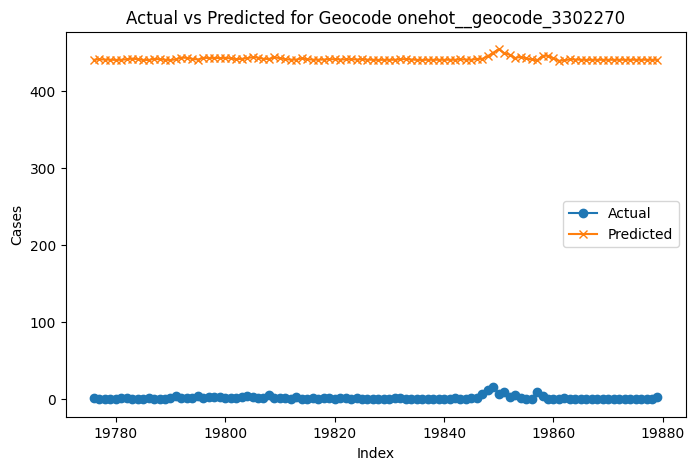

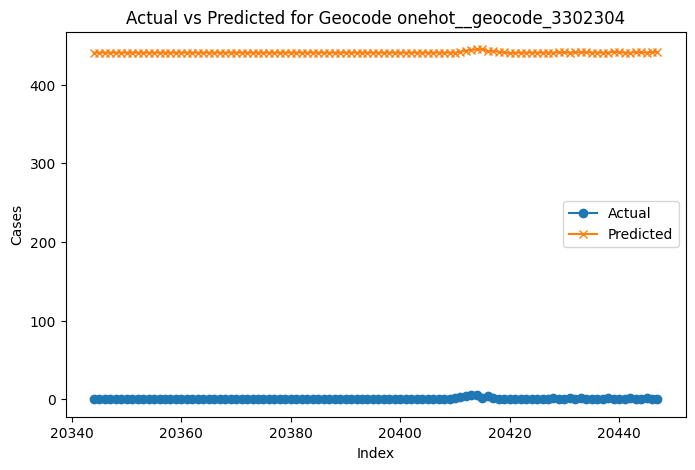

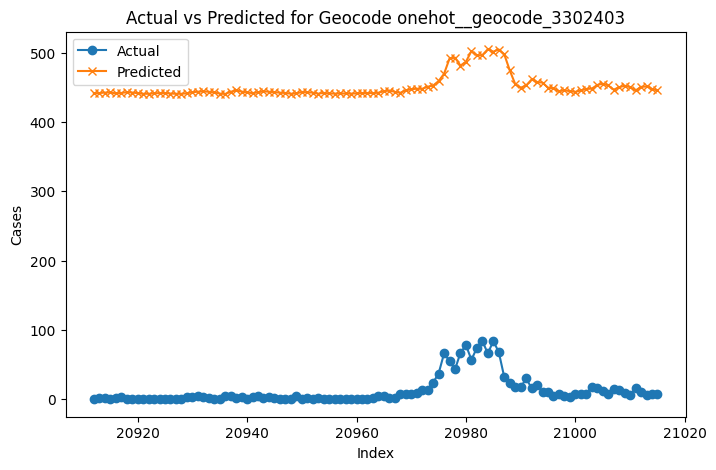

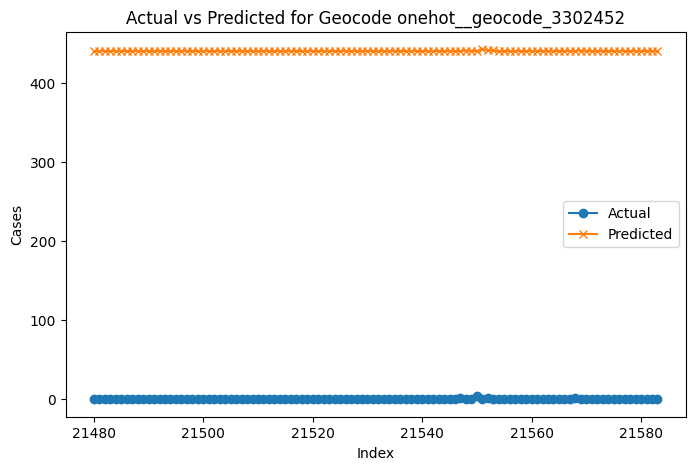

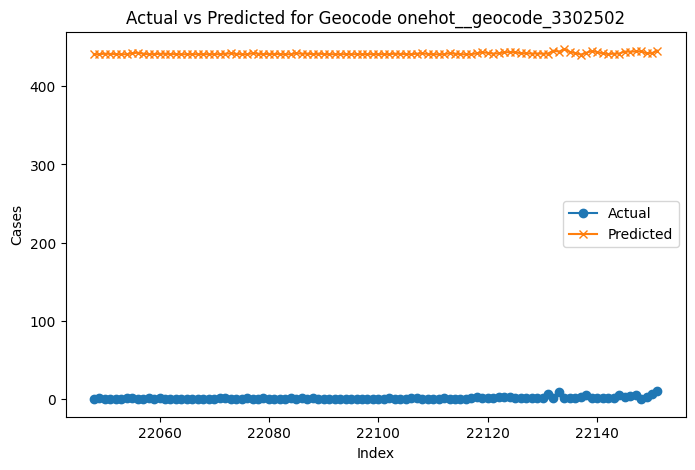

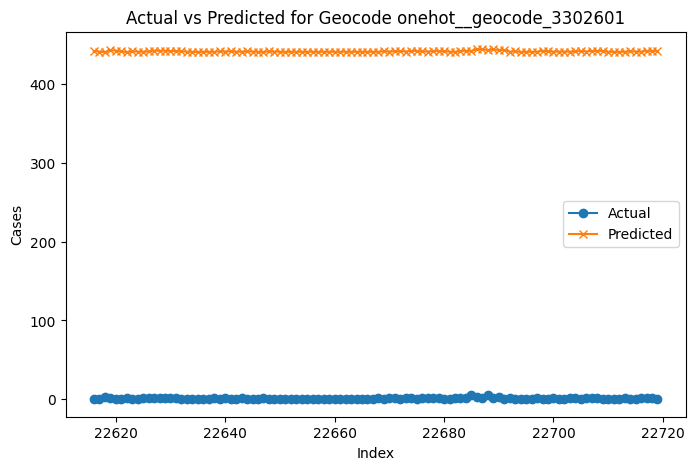

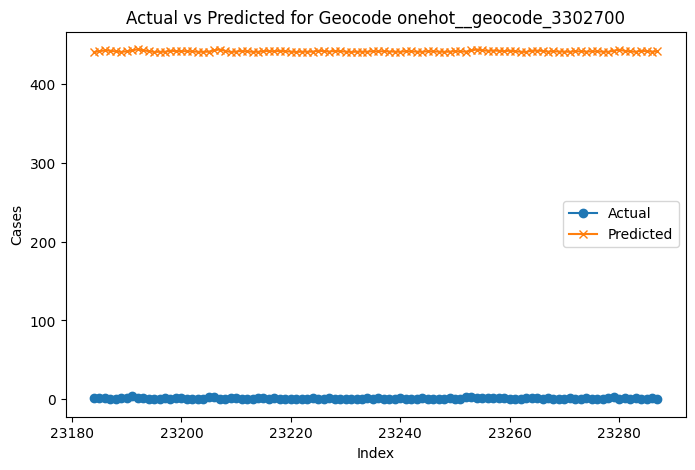

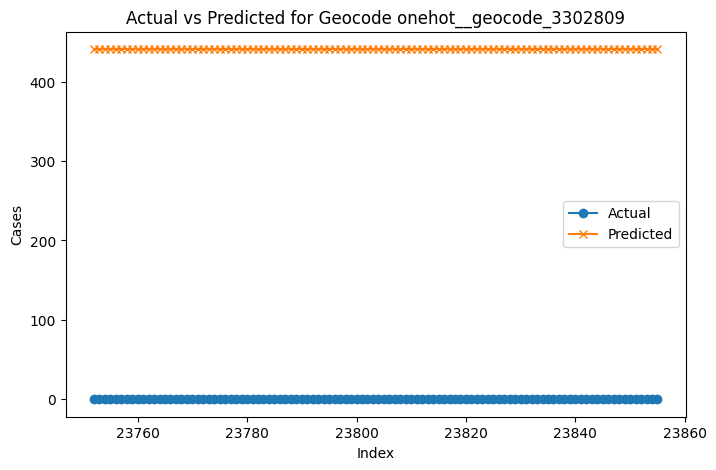

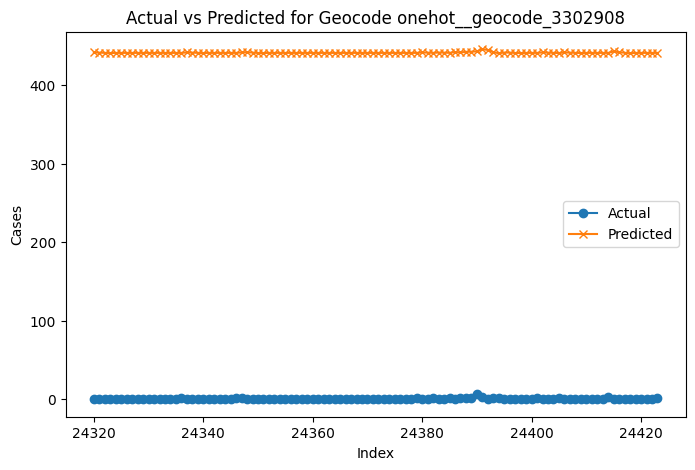

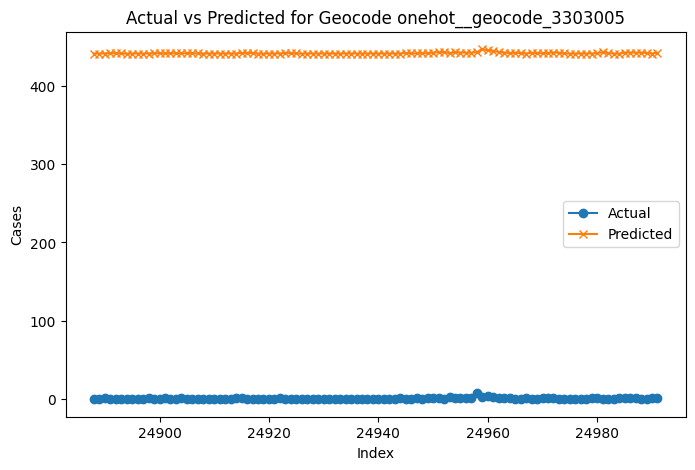

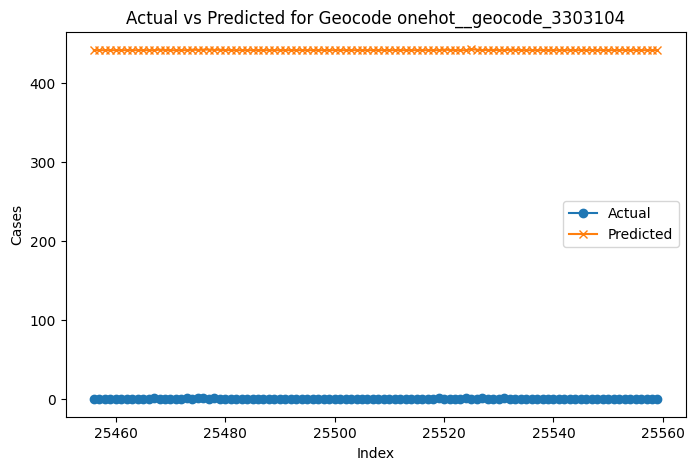

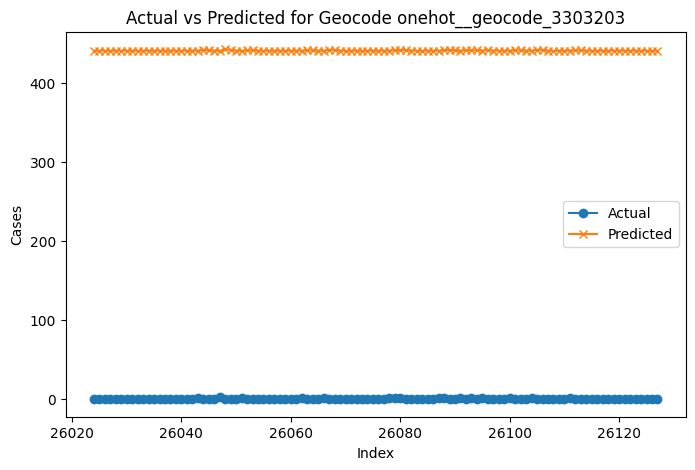

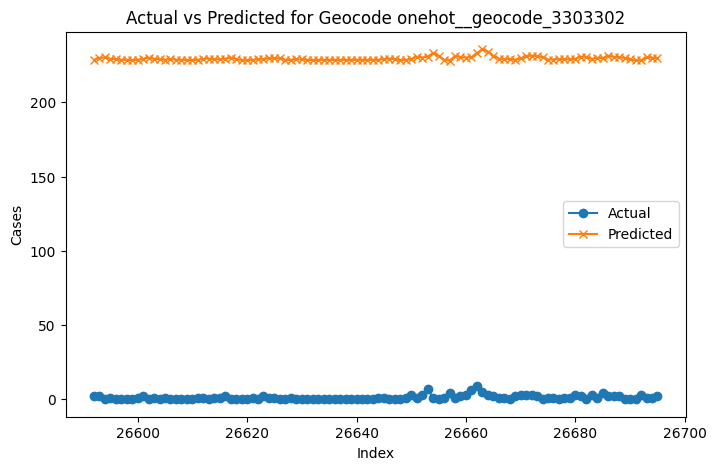

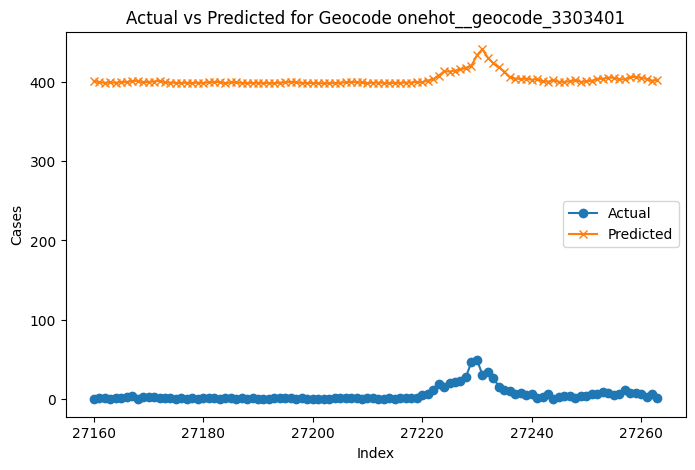

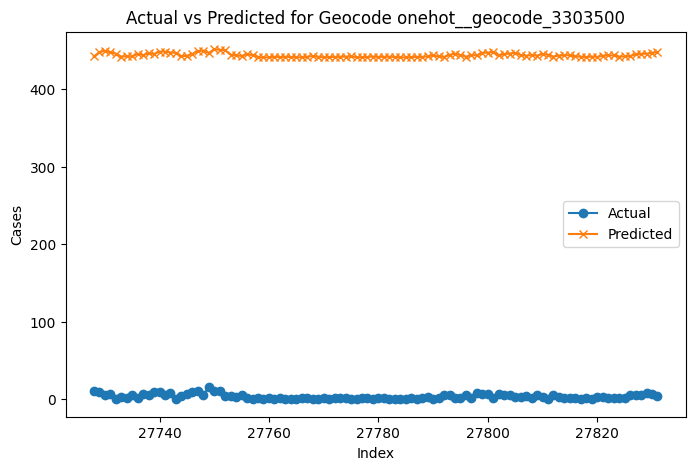

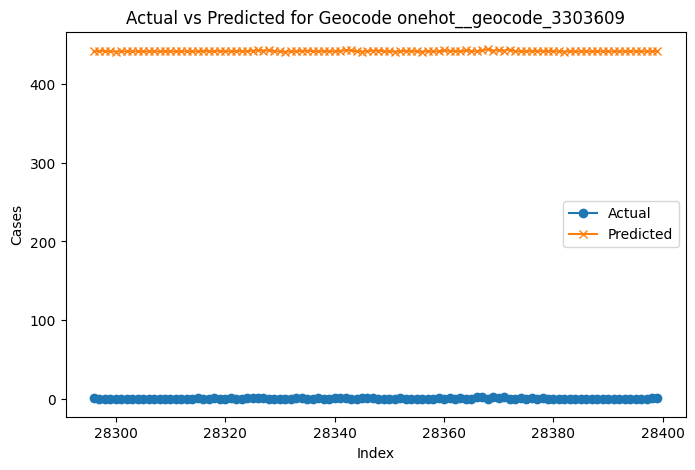

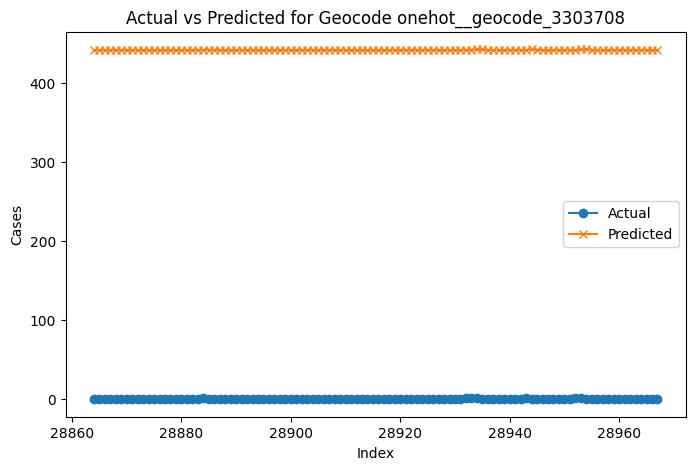

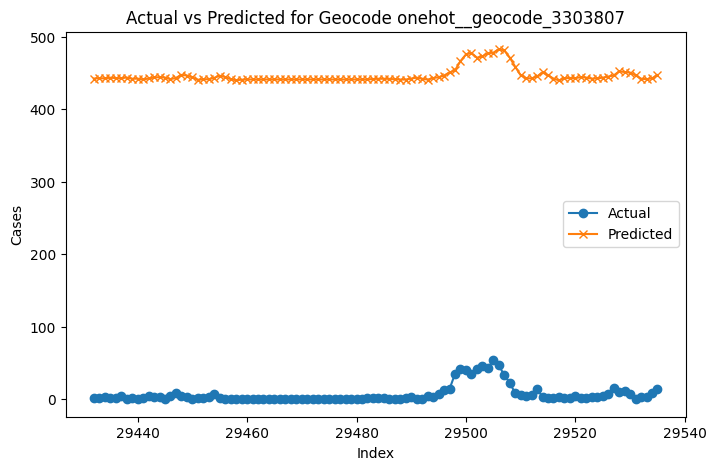

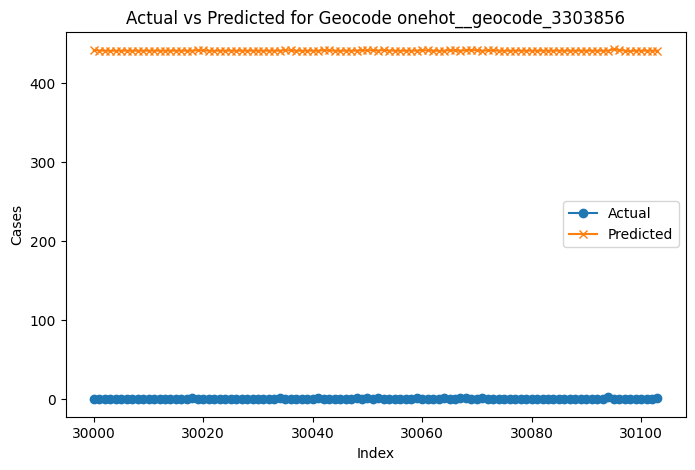

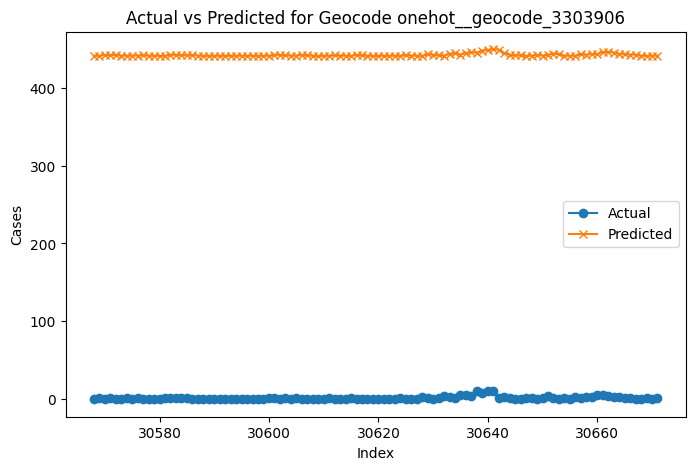

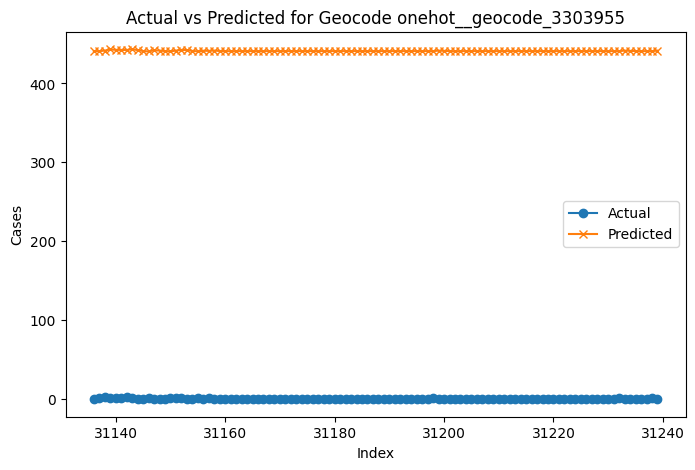

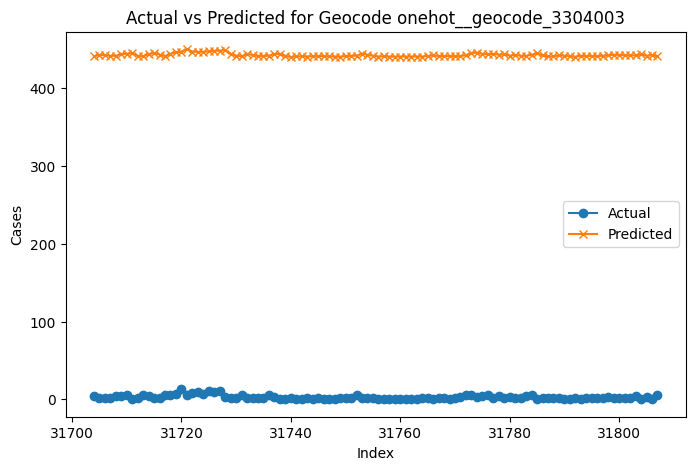

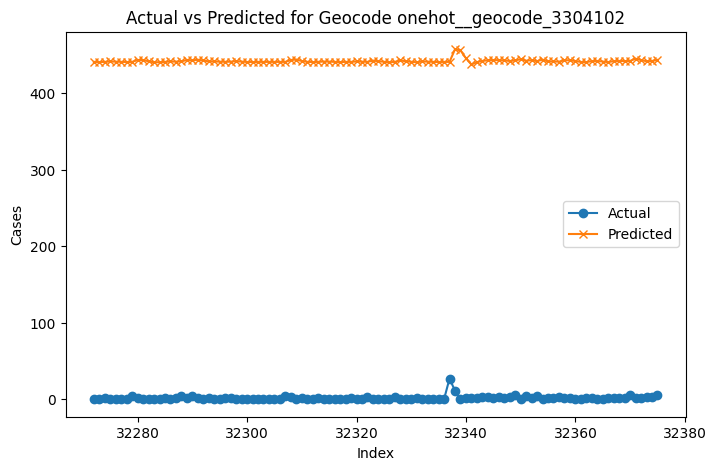

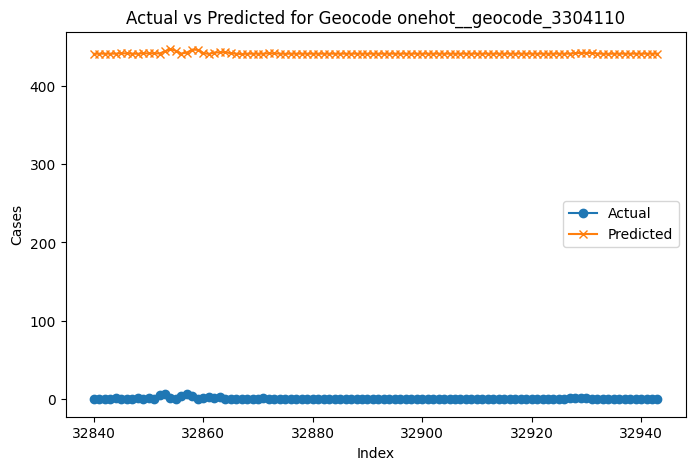

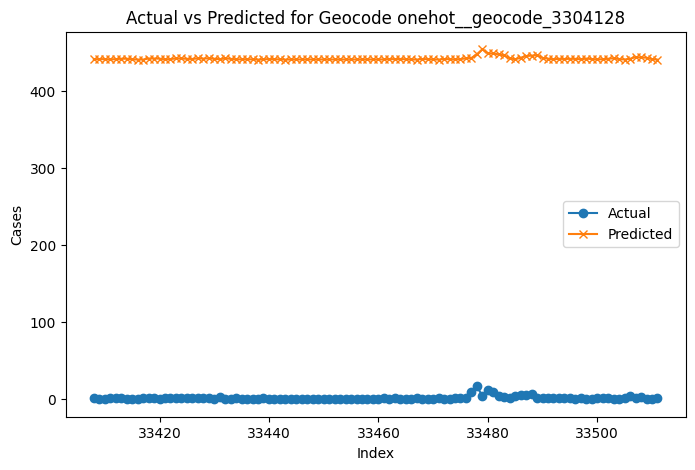

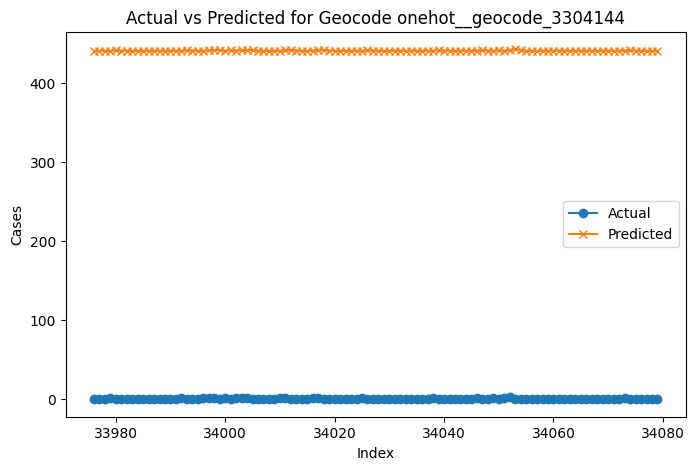

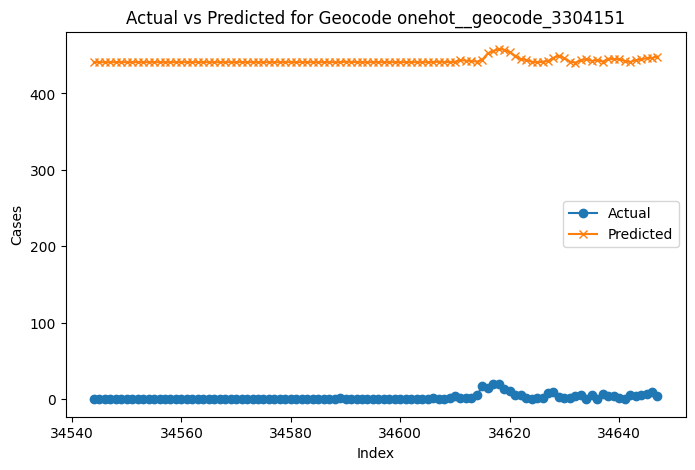

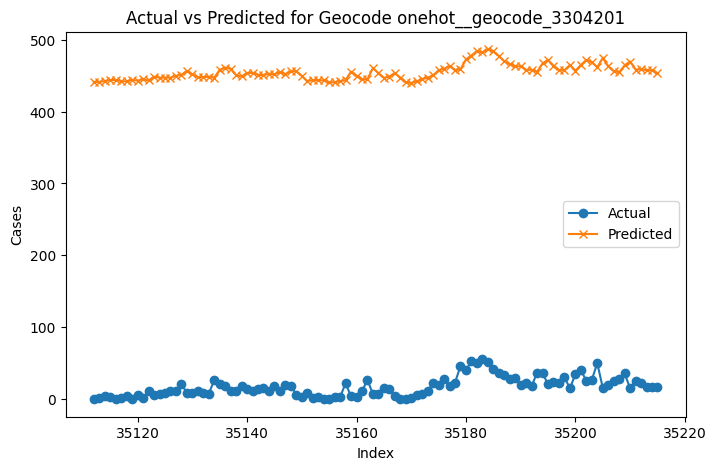

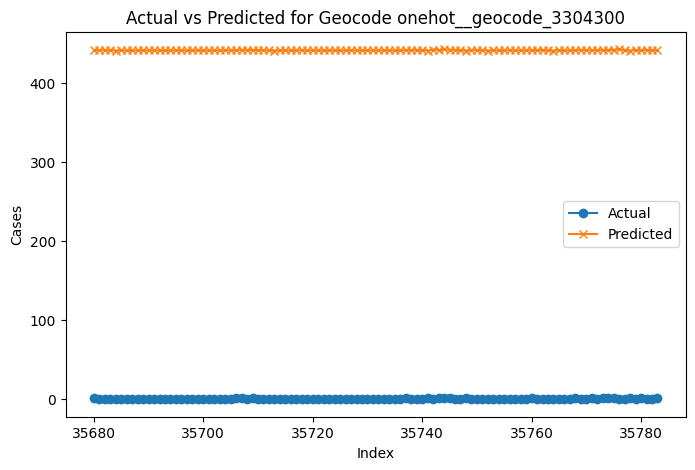

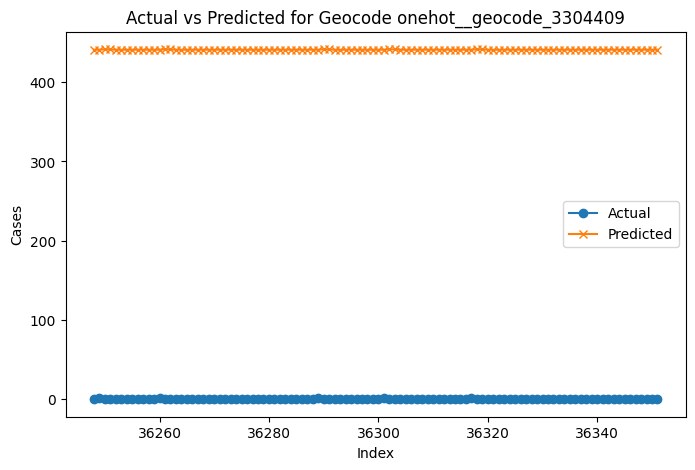

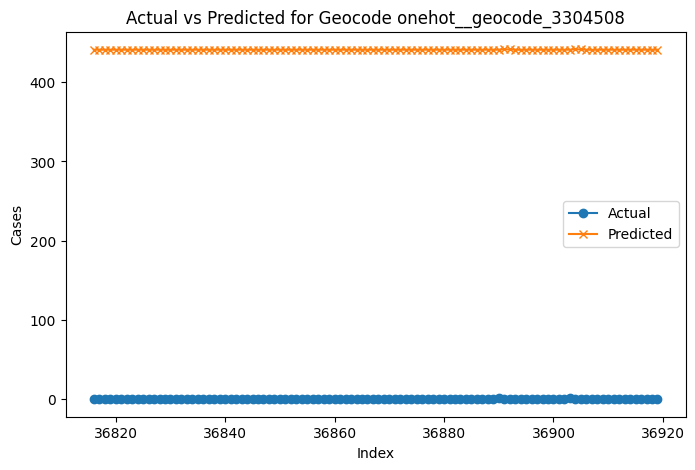

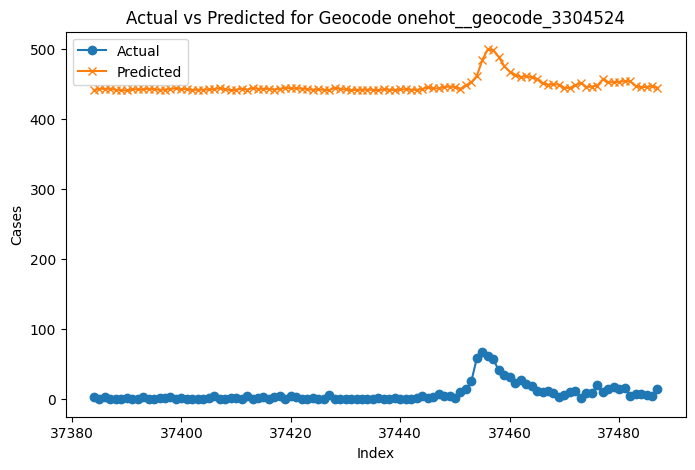

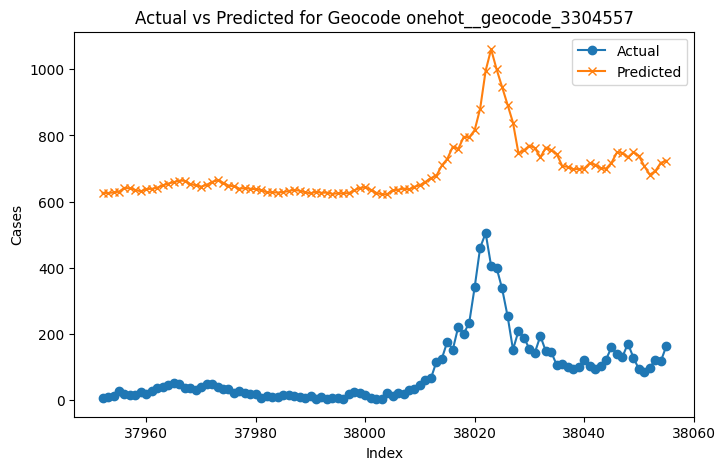

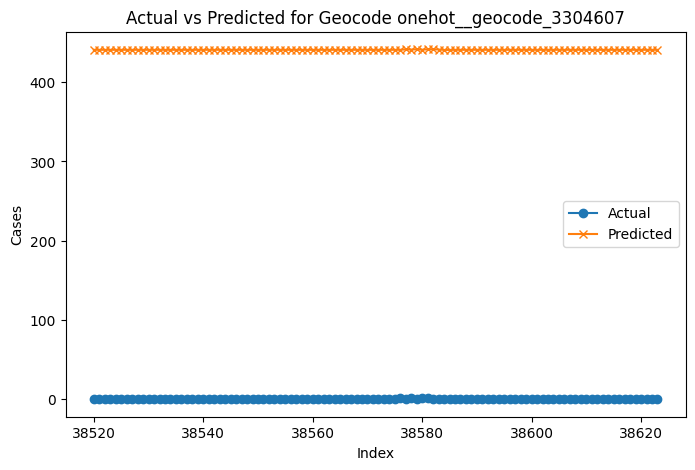

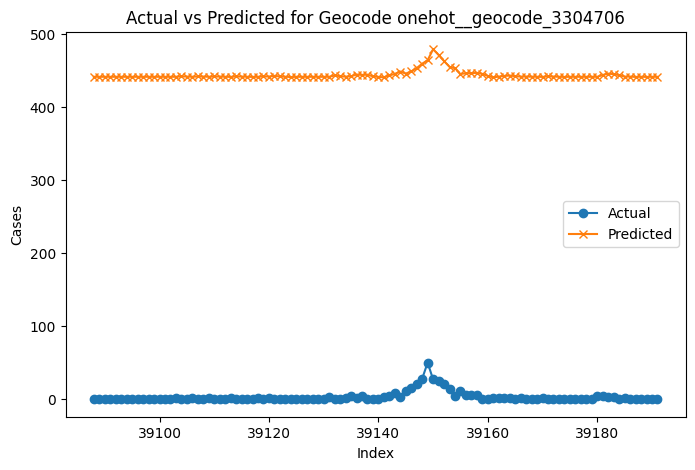

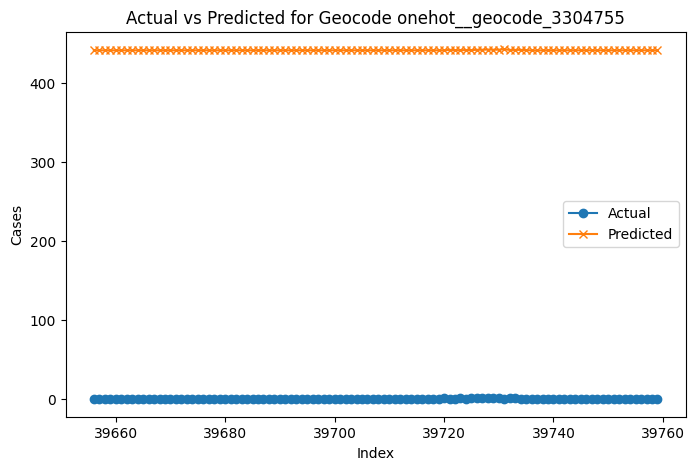

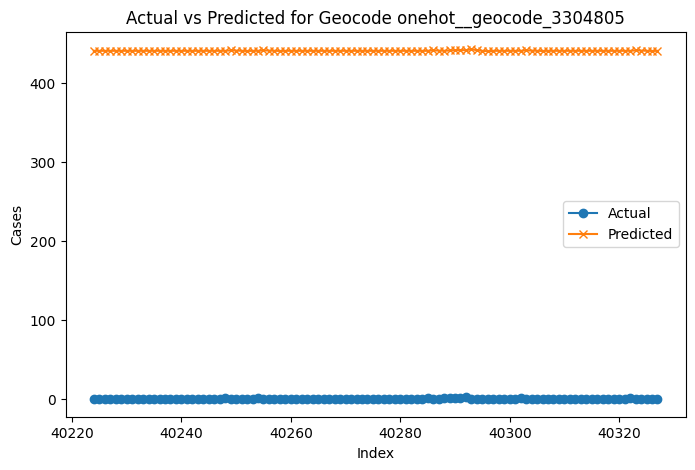

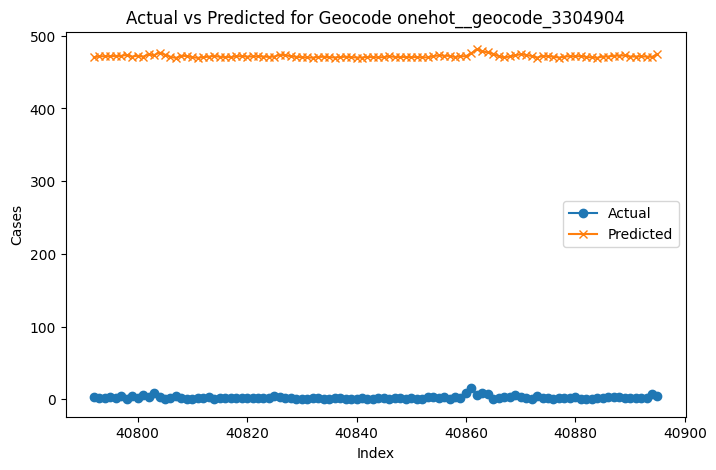

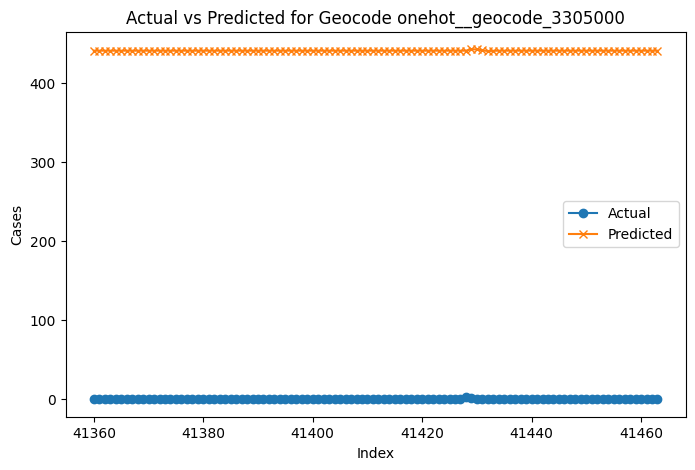

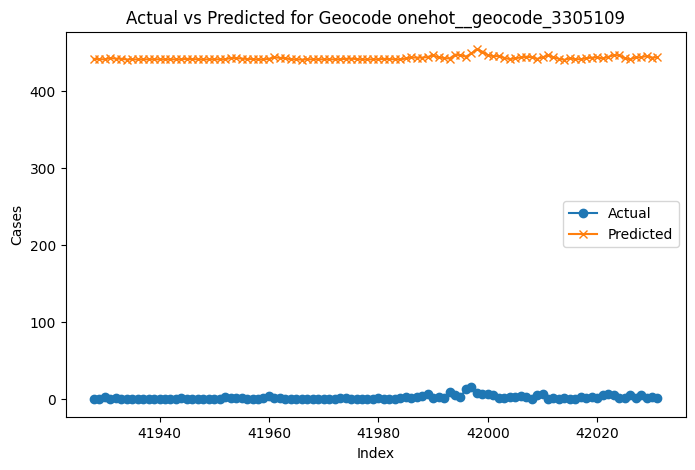

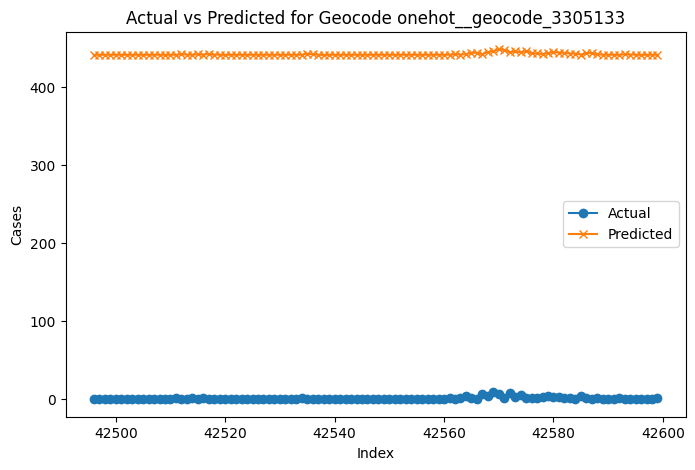

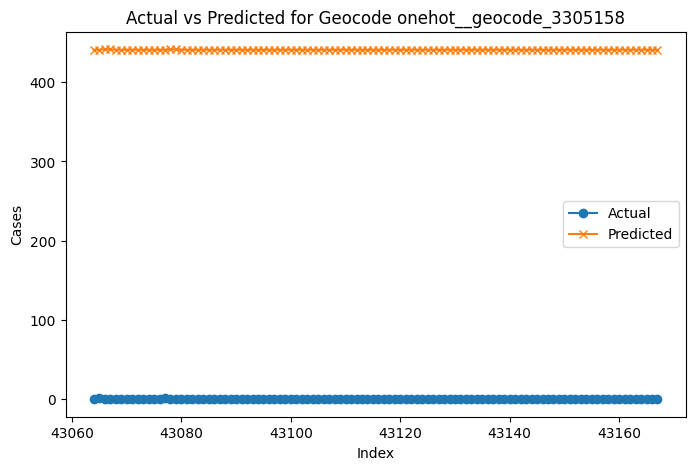

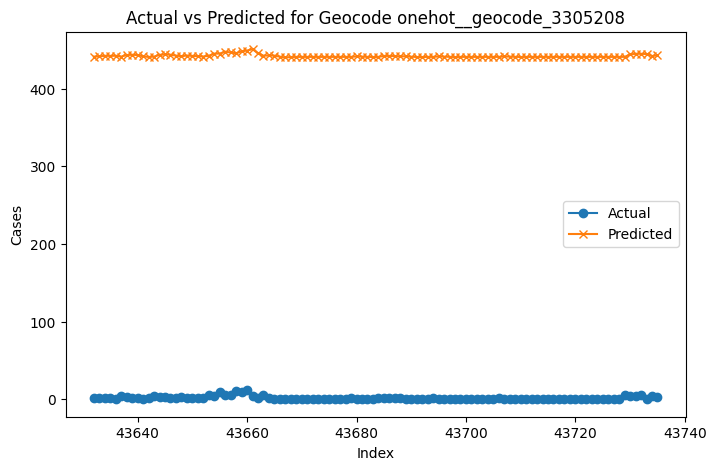

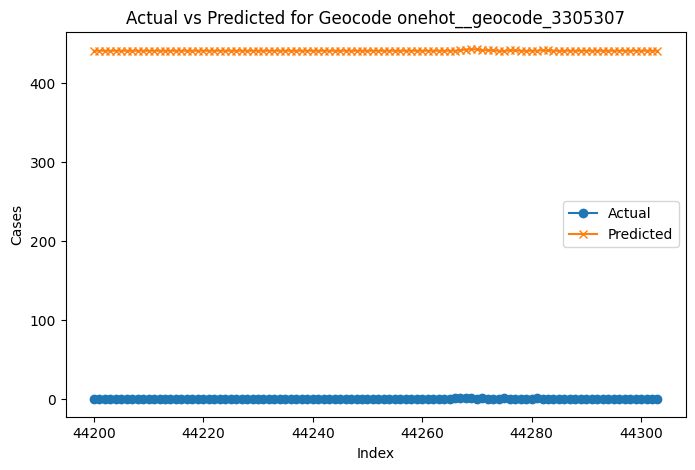

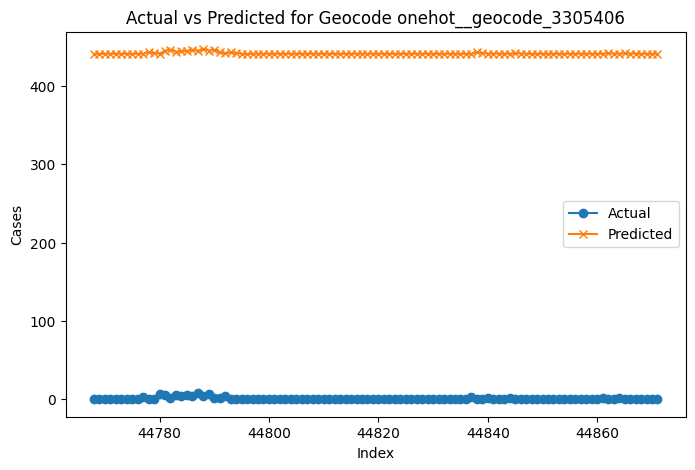

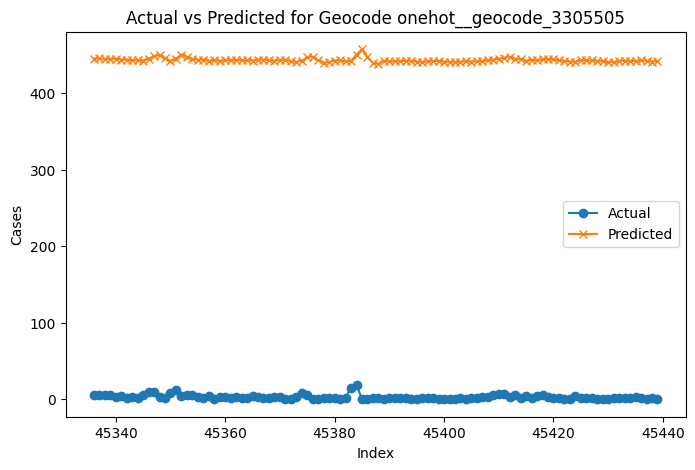

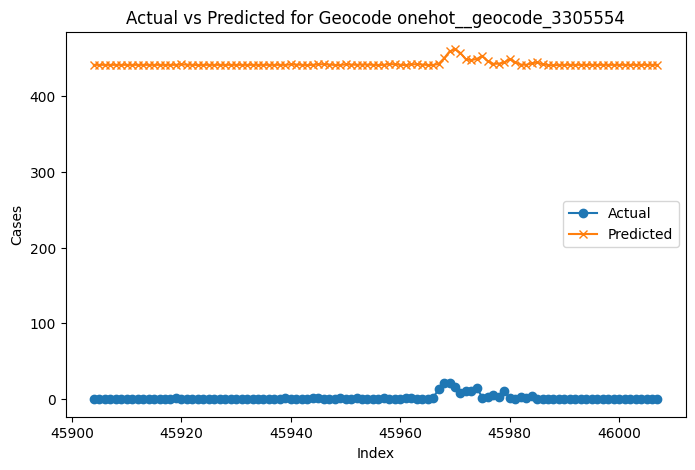

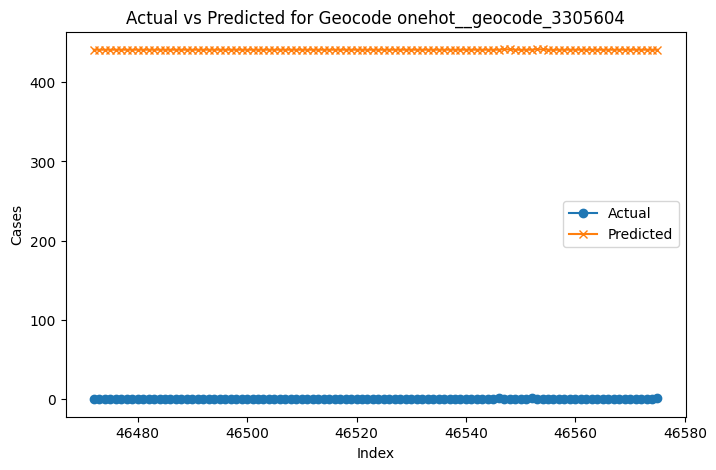

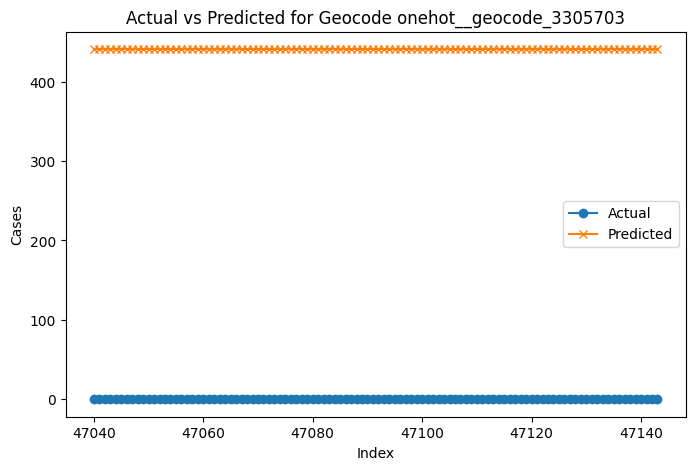

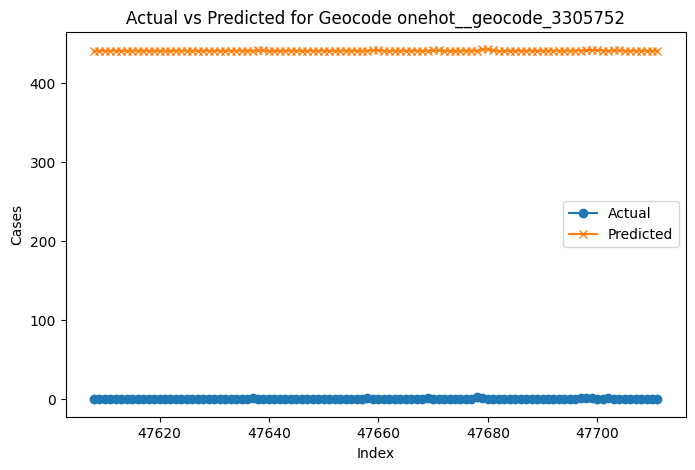

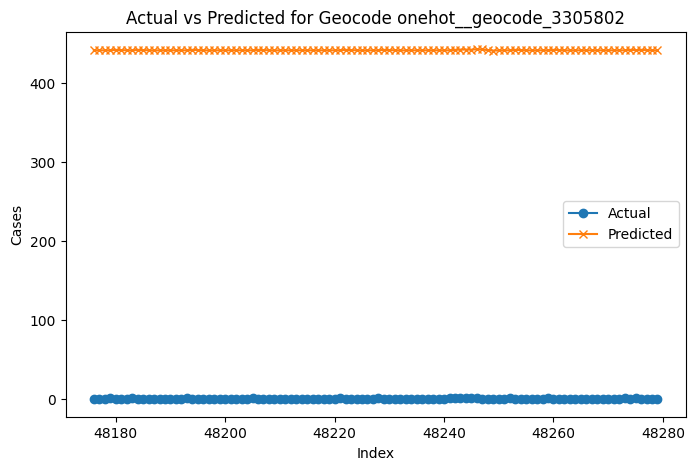

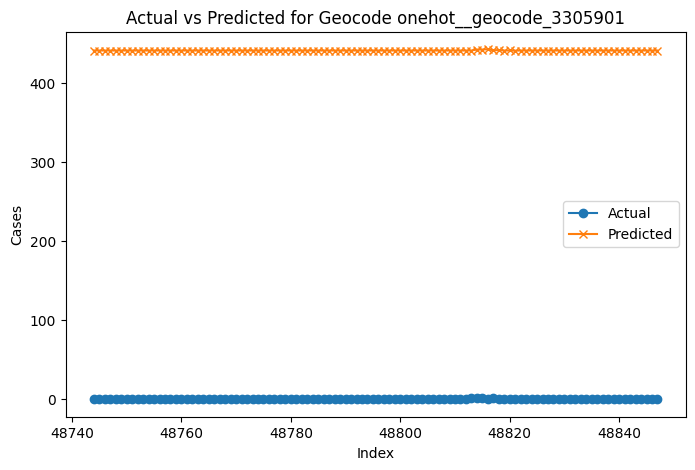

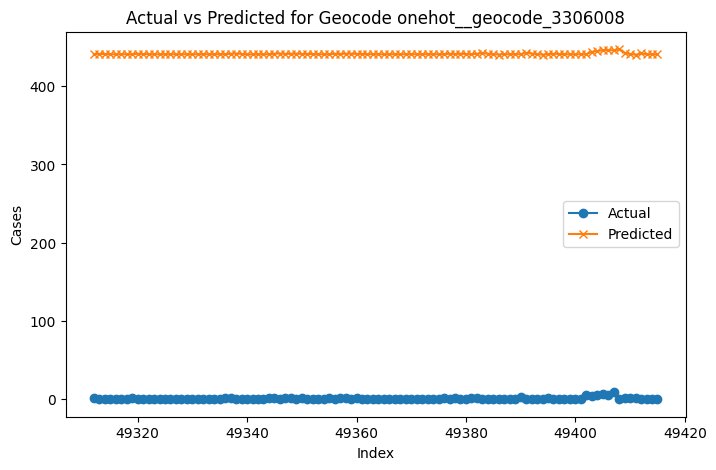

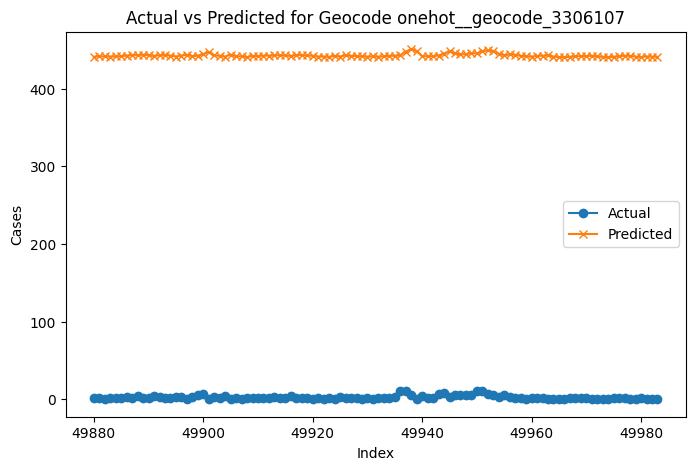

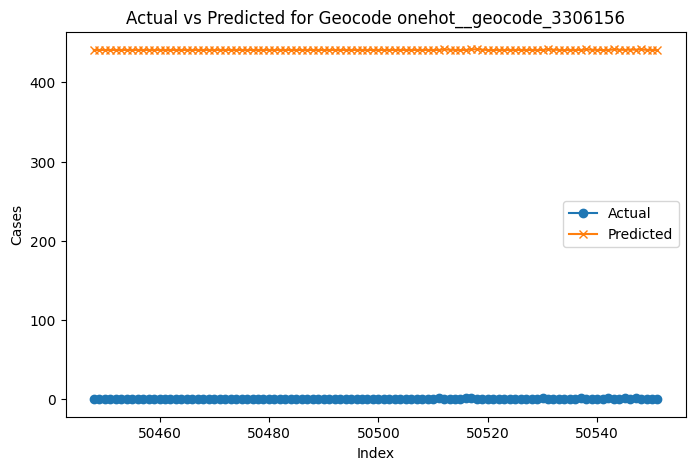

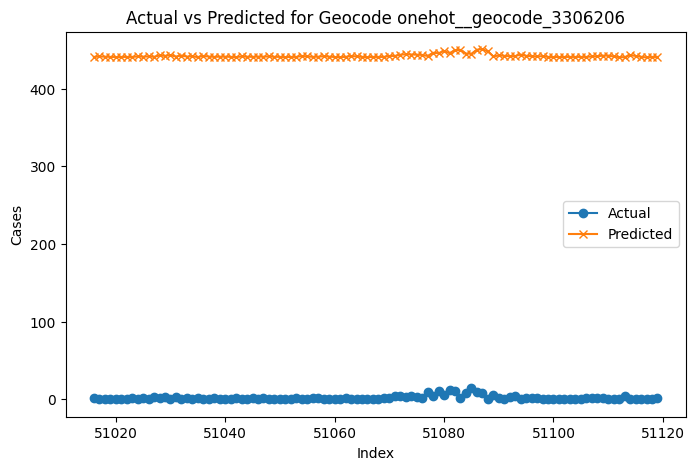

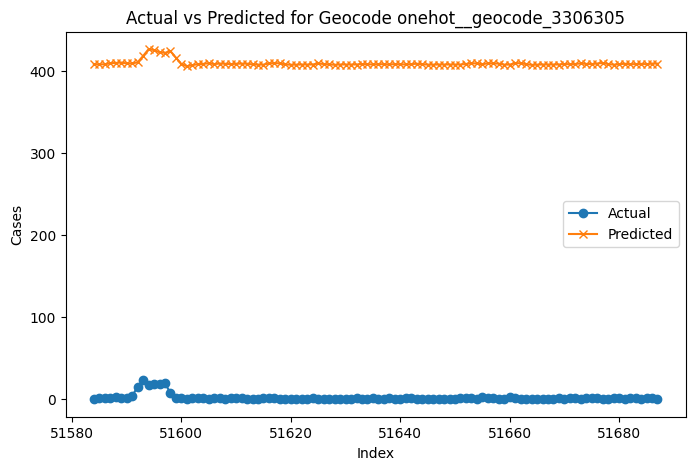

Best SVR Parameters: {'C': 10, 'epsilon': 0.05, 'gamma': 0.01}


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Ensure target is properly scaled
y_train = y_train.ravel()  # Flatten the target array

# Define SVR with hyperparameter tuning
param_grid = {
    "C": [0.1, 1, 10],  # Lower C values to prevent overfitting
    "gamma": [0.01, 0.1, "scale"],  # More flexibility for the model
    "epsilon": [0.05, 0.1, 0.5]  # Higher epsilon to reduce noise sensitivity
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="neg_mean_absolute_error", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_svr = grid_search.best_estimator_

# Predictions
y_pred_scaled = best_svr.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Convert X_test to DataFrame for analysis
X_test_df = pd.DataFrame(X_test, columns=selected_columns)

# Get original y_test values
y_test_original = target_scaler.inverse_transform(y_test)

# Add actual and predicted values
X_test_df["actual"] = y_test_original
X_test_df["predicted"] = y_pred

# Plot Actual vs Predicted for each geocode

# Plot Actual vs Predicted for each one-hot encoded geocode column
for geocode in X_test_df.columns:
    if geocode.startswith('onehot__geocode_'):  # Identify one-hot encoded geocode columns
        # Filter the subset for rows where the current geocode column is 1
        subset = X_test_df[X_test_df[geocode] == 1]
        
        # Plot actual vs predicted cases
        plt.figure(figsize=(8, 5))
        plt.plot(subset.index, subset["actual"], label='Actual', marker='o')
        plt.plot(subset.index, subset["predicted"], label='Predicted', marker='x')
        plt.xlabel("Index")
        plt.ylabel("Cases")
        plt.title(f"Actual vs Predicted for Geocode {geocode}")
        plt.legend()
        plt.show()

# Print best SVR parameters
print("Best SVR Parameters:", grid_search.best_params_)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Assuming X_train, X_test, y_train, y_test are pandas DataFrames and geocode is a column in X_test

# Extract geocode column from test set and remove it from training features
geocode_test = X_test['geocode'].values
X_train = X_train.drop(columns=['geocode'])
X_test = X_test.drop(columns=['geocode'])

# Define SVR and perform GridSearch
svr = SVR()
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train.ravel())

# Get best model
best_svr = grid_search.best_estimator_

# Predictions for test set
y_test_pred = best_svr.predict(X_test)

# Convert to DataFrame for easier manipulation
test_results = pd.DataFrame({
    'Actual': y_test.ravel(),
    'Predicted': y_test_pred,
    'Geocode': geocode_test
})

# Get unique geocodes
unique_geocodes = np.unique(geocode_test)

# Plot for each geocode
for geocode in unique_geocodes:
    test_subset = test_results[test_results['Geocode'] == geocode]

    plt.figure(figsize=(8, 5))
    
    # Scatter plot for actual vs. predicted values
    plt.scatter(range(len(test_subset)), test_subset['Actual'], label="Actual Test", color="blue", alpha=0.6)
    plt.scatter(range(len(test_subset)), test_subset['Predicted'], label="Predicted Test", color="red", marker="x")
    
    plt.xlabel("Sample Index")
    plt.ylabel("Target Value")
    plt.title(f"Predictions vs. Actual for Geocode {geocode}")
    plt.legend()
    plt.show()

print("Best Parameters:", grid_search.best_params_)
